# Imports

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px
import pandas as pd
import numpy as np
import gspread
import seaborn as sns
import calendar
from gspread_dataframe import get_as_dataframe, set_with_dataframe
from gspread_formatting.dataframe import format_with_dataframe
from IPython.core.interactiveshell import InteractiveShell


plt.rcParams["figure.figsize"] = [8, 5]
plt.rcParams["figure.dpi"] = 200

InteractiveShell.ast_node_interactivity = "all"
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

# gs-to-py-api@data-and-analitics-exel.iam.gserviceaccount.com
gc = gspread.service_account()


# Defining a function to calculate consecutive wins per user
def calculate_consecutive_wins_per_user(df):
    """
    Calculate the maximum number of consecutive wins for each user.

    :param df: DataFrame containing user betting data
    :return: DataFrame with each user's maximum consecutive wins
    """

    # Group by user and then calculate consecutive wins
    def max_consecutive_wins(group):
        return (
            group["Result"]
            * (
                group["Result"]
                .groupby((group["Result"] != group["Result"].shift()).cumsum())
                .cumcount()
                + 1
            )
        ).max()

    consecutive_wins = df.groupby("User_id").apply(max_consecutive_wins).reset_index()
    consecutive_wins.columns = ["User_id", "Max_Consecutive_Wins"]

    return consecutive_wins


# Modifying the function to include time period selection


def calculate_consecutive_wins_per_user_with_period(df, frequency):
    """
    Calculate the maximum number of consecutive wins for each user within specified time periods.

    :param df: DataFrame containing user betting data
    :param frequency: Frequency for analysis ('D' for daily, 'W' for weekly, etc.)
    :return: DataFrame with each user's maximum consecutive wins in each period
    """
    # Convert 'Datetime' to datetime format
    df["Datetime"] = pd.to_datetime(df["Datetime"])

    # Function to calculate consecutive wins
    def max_consecutive_wins(group):
        return (
            group["Result"]
            * (
                group["Result"]
                .groupby((group["Result"] != group["Result"].shift()).cumsum())
                .cumcount()
                + 1
            )
        ).max()

    # Group by user and period
    results = []
    for (user_id, period), group in df.groupby(
        ["User_id", pd.Grouper(key="Datetime", freq=frequency)]
    ):
        max_wins = max_consecutive_wins(group)
        start_date = group["Datetime"].min().date()
        end_date = group["Datetime"].max().date()
        results.append(
            {
                "User_id": user_id,
                "Max_Consecutive_Wins": max_wins,
                "Frequency": frequency,
                "Period_Start": start_date,
                "Period_End": end_date,
            }
        )

    return pd.DataFrame(results)


def create_extended_consecutive_wins_table(data):
    # Ensure the data is sorted by User_id and Datetime
    data_sorted = data.sort_values(by=["User_id", "Datetime"])

    # Adding a column for the date (excluding time)
    data_sorted["Date"] = data_sorted["Datetime"].dt.date

    # Calculate consecutive wins and flag for At least one win
    data_sorted["Consecutive Wins"] = data_sorted.groupby(["User_id", "Date"])[
        "Result"
    ].cumsum()
    data_sorted["At least one win"] = (
        data_sorted.groupby(["User_id", "Date"])["Result"].cumsum() == 1
    )

    # Initialize columns for detailed consecutive wins and total amount of consecutive wins
    for i in range(2, 6):
        data_sorted[f"Consecutive Wins {i}"] = (
            data_sorted["Consecutive Wins"] == i
        ).astype(int)
    data_sorted["Consecutive Wins 5+"] = (data_sorted["Consecutive Wins"] >= 5).astype(
        int
    )
    data_sorted["Total Consecutive Wins"] = data_sorted.groupby(["User_id", "Date"])[
        "Consecutive Wins"
    ].transform("max")

    # Calculate the cumulative bet amount, rewards, and rounds/bets per day
    data_sorted["Cumulative Bet Amount"] = data_sorted.groupby(["User_id", "Date"])[
        "Bet amount"
    ].cumsum()
    data_sorted["Rounds/Bets"] = data_sorted.groupby(["User_id", "Date"]).cumcount() + 1
    data_sorted["Rewards"] = data_sorted.apply(
        calculate_reward, axis=1
    )  # Using the calculate_reward function from the previous script
    data_sorted["Total Rewards"] = data_sorted.groupby(["User_id", "Date"])[
        "Rewards"
    ].transform("sum")

    # Selecting relevant columns for the final table
    columns_to_include = [
        "User_id",
        "Date",
        "At least one win",
        # "Total Consecutive Wins",
        "Consecutive Wins 2",
        "Consecutive Wins 3",
        "Consecutive Wins 4",
        "Consecutive Wins 5",
        "Consecutive Wins 5+",
        "Cumulative Bet Amount",
        "Total Rewards",
        "Rounds/Bets",
    ]
    final_table = data_sorted[columns_to_include].drop_duplicates(
        subset=["User_id", "Date"]
    )

    return final_table


def find_first_win(data):
    """
    Function to find the first win of each user.
    Outputs a DataFrame with user_id, round_id, bet_amount, timestamp, and round_order for the first win.
    """
    # Filter out only the wins
    wins_data = data[data["Result"] == 1]

    # Find the first win for each user
    first_wins = wins_data.groupby("User_id").first().reset_index()

    # Selecting only the required columns
    first_wins_output = first_wins[
        ["User_id", "Round_id", "Bet amount", "Datetime", "bet_order"]
    ]

    return first_wins_output

# Data

In [1]:
def generate_valid_combinations_one_step(initial_bet, step_size):
    valid_combinations = []

    # Define the next possible bets based on the current bet
    def next_bets(current_bet):
        return [max(current_bet - step_size, 3), current_bet, min(current_bet + step_size, 21)]

    possible_bets_round_2 = next_bets(initial_bet)
    possible_bets_round_3 = [next_bets(bet_2) for bet_2 in possible_bets_round_2]

    # Generating all valid combinations
    for bet_2 in possible_bets_round_2:
        for bet_3 in possible_bets_round_3[possible_bets_round_2.index(bet_2)]:
            valid_combinations.append((initial_bet, bet_2, bet_3))

    return valid_combinations

# Generate all valid combinations for an initial bet of 3 with one step movement
valid_combinations_for_bet_3_one_step = generate_valid_combinations_one_step(3, 3)

# Extend this logic for all initial bets from 3 to 21
all_bet_scenarios = []
for initial_bet in range(3, 22, 3):  # Bets are in steps of 3 from 3 to 21
    all_bet_scenarios.extend(generate_valid_combinations_one_step(initial_bet, 3))

# Convert all bet scenarios into a pandas DataFrame
df_all_bet_scenarios = pd.DataFrame(all_bet_scenarios, columns=['Round 1 Bet', 'Round 2 Bet', 'Round 3 Bet'])
df_all_bet_scenarios


NameError: name 'pd' is not defined

In [4]:
data = pd.read_csv("../data/__Reward.csv")
# data = data.copy(deep=True)
data["Datetime"] = pd.to_datetime(data["Datetime"])
data["bet_order"] = data.groupby("User_id")["Datetime"].rank(method="first", ascending=True)
data = data.sort_values(by=["User_id", "bet_order"], ascending=True)
data["first_win"] = np.where((data["Result"] == 1) & (data["bet_order"] == 1), 1, 0)

data["bet_after_first_win"] = np.where(
    (data["first_win"].shift() == 1) & (data["bet_order"] > 1), 1, 0
)
data.head()
print("*" * 50)
print(data.shape)
print("*" * 50)
print('Saving data')
data.to_csv("../data/data.csv", index=False)
print("*" * 50)
print("Unique users: ", data["User_id"].nunique())
print("-" * 50)
print("Date range: ", data["Datetime"].min(), data["Datetime"].max())
# data.head().to_clipboard(index=False)

Datetime  User_id  \
8962  2023-12-01 20:07:01.002880      118   
29233 2023-11-06 22:59:52.273310      129   
15429 2023-11-24 02:42:56.150887      129   
17832 2023-11-21 04:06:46.097386      146   
28539 2023-11-07 23:51:28.890570      194   

                                   Round_id  Result  Bet amount  Reward  \
8962   e33abe1c-d54d-4390-bfd3-fa39e57acc20       1       10.00    15.0   
29233  44566a43-6b97-47fb-afb3-647ce19cb455       0        1.00     0.0   
15429  87027675-df20-469e-acdb-82d519f5aa86       0        0.50     0.0   
17832  d88aa4ad-607c-4d27-86eb-36956cdb2971       0        9.99     0.0   
28539  7e43fcfd-198b-4bcb-9f40-3f117125a5a4       0        8.44     0.0   

       bet_order  first_win  bet_after_first_win  
8962         1.0          1                    0  
29233        1.0          0                    0  
15429        2.0          0                    0  
17832        1.0          0                    0  
28539        1.0          0                    0

**************************************************
(47324, 9)
**************************************************
Saving data
**************************************************
Unique users:  12660
--------------------------------------------------
Date range:  2023-10-11 00:00:31.974374 2023-12-11 08:33:19.737187


In [5]:
# Calculate the lower and upper bounds for each bin
inital_bet_bins = [3,6,9,12,15,18,21]
bin_bounds = [bet * 0.8 for bet in inital_bet_bins] + [bet * 1.2 for bet in inital_bet_bins[-1:]]

# Assign the bin number based on the bet amount
data['bet_bins'] = pd.cut(data['Bet amount'], bins=bin_bounds, labels=inital_bet_bins, right=False)
bet_order = 1
dt = data[data['bet_order']==bet_order].groupby('bet_bins').agg({
    'User_id':'nunique',
    'Round_id':'nunique',
    'Bet amount':'mean',
    'Reward':'mean',
}).rename(columns={
    'User_id':'total_users',
    'Round_id':'total_rounds',
    'Bet amount':'average_bet_amount',
    'Reward':'average_reward',
})
dt['average_reward_per_bet'] = dt['average_reward']/dt['average_bet_amount']
dt['bet_order'] = bet_order
dt['bettting_probabilities'] = dt['total_users']/dt['total_users'].sum()
dt

/var/folders/6y/p69wgs_n4cn8pyp7ly6k1f6m0000gn/T/ipykernel_31694/3106385146.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dt = data[data['bet_order']==bet_order].groupby('bet_bins').agg({


total_users  total_rounds  average_bet_amount  average_reward  \
bet_bins                                                                  
3                 210           210            4.274286        2.280619   
6                1025          1025            5.024576        2.507112   
9                 508           508            8.605827        4.595118   
12               4401          4401           10.063079        4.572629   
15                  7             7           12.291429        2.614286   
18                  0             0                 NaN             NaN   
21                 21            21           20.322857        8.611905   

          average_reward_per_bet  bet_order  bettting_probabilities  
bet_bins                                                             
3                       0.533567          1                0.034025  
6                       0.498970          1                0.166073  
9                       0.533954          1                0.082307  
12                      0.454397          1                0.713059  
15                      0.212692          1                0.001134  
18                           NaN          1                0.000000  
21                      0.423755          1                0.003402

In [6]:
# Apply the function to find the first win for each user
first_wins_data = find_first_win(data)
first_wins_data.head()

User_id                              Round_id  Bet amount  \
0      118  e33abe1c-d54d-4390-bfd3-fa39e57acc20        10.0   
1      435  0db966bc-274c-4920-9046-401e77c0ca12         0.5   
2      546  4394e5df-37a0-43fd-bf6f-3b37fae75d6f        10.0   
3     1330  4cd3cbab-df86-4ef5-b652-1b96f9ec6d77         5.0   
4     1585  fe081780-e6aa-4930-9086-0223d6a8a6fe         0.5   

                    Datetime  bet_order  
0 2023-12-01 20:07:01.002880        1.0  
1 2023-10-20 04:59:47.073779        1.0  
2 2023-10-17 10:47:10.971814        1.0  
3 2023-12-03 08:52:32.913051        1.0  
4 2023-12-01 05:28:38.175744        3.0

In [7]:
user_win_rate = data.groupby(["User_id"], as_index=False).agg(
    {"Round_id": "nunique", "Result": "sum", "Bet amount": "sum", "Reward": "sum"}
)
user_win_rate = user_win_rate.rename(
    columns={
        "Round_id": "total_rounts",
        "Result": "total_wins",
        "Bet amount": "total_bet_amount",
        "Reward": "total_wins_amount",
    }
)

user_win_rate["win_rate"] = user_win_rate["total_wins"] / user_win_rate["total_rounts"]
user_win_rate.head()

User_id  total_rounts  total_wins  total_bet_amount  total_wins_amount  \
0      118             1           1             10.00               15.0   
1      129             2           0              1.50                0.0   
2      146             1           0              9.99                0.0   
3      194             1           0              8.44                0.0   
4      435             5           2              2.50                1.5   

   win_rate  
0       1.0  
1       0.0  
2       0.0  
3       0.0  
4       0.4

In [8]:
# Calculating consecutive wins per user
consecutive_wins_per_user = calculate_consecutive_wins_per_user(data)
consecutive_wins_per_user.head()

User_id  Max_Consecutive_Wins
0      118                     1
1      129                     0
2      146                     0
3      194                     0
4      435                     2

In [9]:
# Example usage: Calculating consecutive wins per user on a daily basis
consecutive_wins_per_user_daily = calculate_consecutive_wins_per_user_with_period(
    data, "D"
)
consecutive_wins_per_user_daily.head()

User_id  Max_Consecutive_Wins Frequency Period_Start  Period_End
0      118                     1         D   2023-12-01  2023-12-01
1      129                     0         D   2023-11-06  2023-11-06
2      129                     0         D   2023-11-24  2023-11-24
3      146                     0         D   2023-11-21  2023-11-21
4      194                     0         D   2023-11-07  2023-11-07

In [10]:
# Example usage: Calculating consecutive wins per user on a daily basis
consecutive_wins_per_user_daily = calculate_consecutive_wins_per_user_with_period(
    data, "W"
)
consecutive_wins_per_user_daily.head()

User_id  Max_Consecutive_Wins Frequency Period_Start  Period_End
0      118                     1         W   2023-12-01  2023-12-01
1      129                     0         W   2023-11-06  2023-11-06
2      129                     0         W   2023-11-24  2023-11-24
3      146                     0         W   2023-11-21  2023-11-21
4      194                     0         W   2023-11-07  2023-11-07

In [11]:
def calculate_consecutive_wins_per_week(df):
    """
    Function to calculate consecutive wins and other stats on a weekly level.
    """
    # Initialize a dictionary to hold weekly data
    weekly_stats = []

    # Loop through each week in the dataset
    for week_start, week_df in df.set_index("Datetime").resample("W"):
        # Basic stats
        total_users = week_df["User_id"].nunique()
        total_rounds = week_df["Round_id"].nunique()
        total_bet = week_df["Bet amount"].sum()
        total_rewards = week_df["Reward"].sum()
        win_rate = week_df["Result"].mean()

        # Calculate consecutive wins
        week_df["Win_Streak"] = (week_df["Result"] == 1).cumsum() - (
            week_df["Result"] == 1
        ).cumsum().where(week_df["Result"] == 0).ffill().fillna(0)

        # Count the users who achieved at least 1, 2, 3, and more than 3 consecutive wins
        at_least_1_win = week_df[week_df["Win_Streak"] >= 1]["User_id"].nunique()
        at_least_2_win = week_df[week_df["Win_Streak"] >= 2]["User_id"].nunique()
        at_least_3_win = week_df[week_df["Win_Streak"] >= 3]["User_id"].nunique()
        more_than_3_win = week_df[week_df["Win_Streak"] >= 4]["User_id"].nunique()

        # Compile the weekly stats
        weekly_stats.append(
            {
                "week_start_date": week_start,
                "total_users": total_users,
                "total_rounds": total_rounds,
                "total_bet": total_bet,
                "total_rewards": total_rewards,
                "win_rate": win_rate,
                "at_least_1_win": at_least_1_win,
                "2_in_a_row": at_least_2_win,
                "3_in_a_row": at_least_3_win,
                "more_than_3_in_a_row": more_than_3_win,
            }
        )

    return pd.DataFrame(weekly_stats)


# Apply the function to the dataframe and display the results
weekly_stats_refined = calculate_consecutive_wins_per_week(data)
weekly_stats_refined['avg_rounds_per_user'] = weekly_stats_refined['total_rounds']/weekly_stats_refined['total_users']
weekly_stats_refined

/var/folders/6y/p69wgs_n4cn8pyp7ly6k1f6m0000gn/T/ipykernel_31694/1802331102.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  week_df["Win_Streak"] = (week_df["Result"] == 1).cumsum() - (
/var/folders/6y/p69wgs_n4cn8pyp7ly6k1f6m0000gn/T/ipykernel_31694/1802331102.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  week_df["Win_Streak"] = (week_df["Result"] == 1).cumsum() - (
/var/folders/6y/p69wgs_n4cn8pyp7ly6k1f6m0000gn/T/ipykernel_31694/1802331102.py:18: SettingWithCopyWarning: 
A value is trying to b

week_start_date  total_users  total_rounds  total_bet  total_rewards  \
0      2023-10-15         1366          3227   11698.21        5738.14   
1      2023-10-22         1557          4501   15470.37        8525.08   
2      2023-10-29         1497          4636   16048.86        9013.38   
3      2023-11-05         1475          4902   13780.99        6791.95   
4      2023-11-12         1616          5743   15375.25        8355.90   
5      2023-11-19         1598          5605   16399.30        8561.11   
6      2023-11-26         1616          5543   16040.53        8838.65   
7      2023-12-03         1901          6257   20163.03       11157.50   
8      2023-12-10         2061          6684   20843.00       10625.60   
9      2023-12-17           78           226     531.56         295.80   

   win_rate  at_least_1_win  2_in_a_row  3_in_a_row  more_than_3_in_a_row  \
0  0.323520             583         235          95                    38   
1  0.374361             786         371         176                    83   
2  0.367990             764         370         172                    77   
3  0.356997             716         338         155                    63   
4  0.383946             865         416         207                    90   
5  0.387333             840         409         208                    94   
6  0.376150             775         391         183                    77   
7  0.375739             949         468         210                    80   
8  0.362956            1009         490         218                    89   
9  0.358407              39          24           9                     2   

   avg_rounds_per_user  
0             2.362372  
1             2.890816  
2             3.096860  
3             3.323390  
4             3.553837  
5             3.507509  
6             3.430074  
7             3.291426  
8             3.243086  
9             2.897436

In [12]:
def calculate_user_daily_stats(df):
    # Create a new DataFrame to hold the user-level daily stats
    user_daily_stats = []

    # Group by date and user
    for (date, user_id), group in df.groupby([df["Datetime"].dt.date, "User_id"]):
        total_bets = group["Bet amount"].sum()
        total_rounds = group.shape[0]
        total_wins = group["Result"].sum()
        total_payout = group["Reward"].sum()

        # Calculating win streaks
        group["Win_Streak"] = (group["Result"] == 1).cumsum() - (
            group["Result"] == 1
        ).cumsum().where(group["Result"] == 0).ffill().fillna(0)

        # Getting the bet amount for the first, second, and third wins in a row
        first_win_bet_amount = group[group["Win_Streak"] == 1]["Bet amount"].sum()
        second_win_in_a_row_bet_amount = group[group["Win_Streak"] == 2][
            "Bet amount"
        ].sum()
        third_win_in_a_row_bet_amount = group[group["Win_Streak"] == 3][
            "Bet amount"
        ].sum()

        # Calculate what-if multiplier for each win streak
        what_if_multiplier_first_win = (
            group[group["Win_Streak"] == 1]["Bet amount"].sum() * 1.5
        )
        what_if_multiplier_second_win = (
            group[group["Win_Streak"] == 2]["Bet amount"].sum() * 2
        )
        what_if_multiplier_third_win = (
            group[group["Win_Streak"] == 3]["Bet amount"].sum() * 10
        )

        # Compile the daily stats for the user
        user_daily_stats.append(
            {
                "date": date,
                "user_id": user_id,
                "first_win_bet_amount": first_win_bet_amount,
                "second_win_in_a_row_bet_amount": second_win_in_a_row_bet_amount,
                "third_win_in_a_row_bet_amount": third_win_in_a_row_bet_amount,
                "total_bets": total_bets,
                "total_rounds": total_rounds,
                "total_wins": total_wins,
                "total_payout": total_payout,
                "what_if_multiplier_first_win": what_if_multiplier_first_win,
                "what_if_multiplier_second_win": what_if_multiplier_second_win,
                "what_if_multiplier_third_win": what_if_multiplier_third_win,
            }
        )

    return pd.DataFrame(user_daily_stats)


user_daily_stats_df = calculate_user_daily_stats(data)
user_daily_stats_df.head()

date  user_id  first_win_bet_amount  second_win_in_a_row_bet_amount  \
0  2023-10-11    10159                   0.0                             0.0   
1  2023-10-11    29788                   1.0                             1.0   
2  2023-10-11    35546                   0.0                             0.0   
3  2023-10-11    42402                   0.0                             0.0   
4  2023-10-11    71049                   0.0                             0.0   

   third_win_in_a_row_bet_amount  total_bets  total_rounds  total_wins  \
0                            0.0        1.98             1           0   
1                            1.0        3.00             3           3   
2                            0.0        3.87             1           0   
3                            0.0       20.00             2           0   
4                            0.0        5.00             1           0   

   total_payout  what_if_multiplier_first_win  what_if_multiplier_second_win  \
0           0.0                           0.0                            0.0   
1           4.5                           1.5                            2.0   
2           0.0                           0.0                            0.0   
3           0.0                           0.0                            0.0   
4           0.0                           0.0                            0.0   

   what_if_multiplier_third_win  
0                           0.0  
1                          10.0  
2                           0.0  
3                           0.0  
4                           0.0

# EDA

In [129]:
# import pandas as pd
# import plotly.graph_objects as go

# def create_sankey_diagram(data):
#     # Preprocess the data: Sort and group by User_id
#     data = data.sort_values(by=['User_id', 'Datetime'])
#     data['bet_order'] = data.groupby('User_id').cumcount() + 1  # Ensure correct bet order

#     # Prepare data for the Sankey diagram
#     stages = ['1st Bet', '1st Bet Win', '1st Bet Loss', '2nd Bet', '2nd Bet Win', '2nd Bet Loss', '3rd Bet']
#     source = []
#     target = []
#     value = []
    
#     # Define flows between nodes
#     for user_id, group in data.groupby('User_id'):
#         for i in range(1, min(4, len(group) + 1)):
#             if i == 1:
#                 source.append(stages.index('1st Bet'))
#                 if group.iloc[i-1]['Result'] == 1:
#                     target.append(stages.index('1st Bet Win'))
#                 else:
#                     target.append(stages.index('1st Bet Loss'))
#                 value.append(1)
#             elif i == 2:
#                 if group.iloc[i-2]['Result'] == 1:
#                     source.append(stages.index('1st Bet Win'))
#                 else:
#                     source.append(stages.index('1st Bet Loss'))
#                 source.append(stages.index('2nd Bet'))
#                 if group.iloc[i-1]['Result'] == 1:
#                     target.append(stages.index('2nd Bet Win'))
#                 else:
#                     target.append(stages.index('2nd Bet Loss'))
#                 value.append(1)
#             elif i == 3:
#                 if group.iloc[i-2]['Result'] == 1:
#                     source.append(stages.index('2nd Bet Win'))
#                 else:
#                     source.append(stages.index('2nd Bet Loss'))
#                 target.append(stages.index('3rd Bet'))
#                 value.append(1)

#     # Create the Sankey diagram
#     fig = go.Figure(data=[go.Sankey(
#         node=dict(
#             pad=15,
#             thickness=20,
#             line=dict(color='black', width=0.5),
#             label=stages
#         ),
#         link=dict(
#             source=source,
#             target=target,
#             value=value
#         ))])

#     fig.update_layout(title_text='User Flow from First to Third Bet', font_size=10)
#     fig.show()

# create_sankey_diagram(data)

## Top-line

In [13]:
# Correcting the issue and recalculating the baseline

# Ensuring 'Datetime' is recognized for resampling
dat = data.copy(deep=True)
dat.set_index('Datetime', inplace=True)

# Recalculating the weekly average GGR (Gross Gaming Revenue)
# weekly_ggr = dat['Reward'].resample('W').sum().mean()
weekly_ggr = (dat['Bet amount'] - dat['Reward']).resample('W').sum().mean()

# Recalculating the weekly average number of rounds
weekly_rounds = dat['Round_id'].resample('W').nunique().mean()

# Recalculating the weekly average number of players
weekly_players = dat['User_id'].resample('W').nunique().mean()

baseline = {
    'Weekly Average GGR': weekly_ggr,
    'Weekly Average Rounds': weekly_rounds,
    'Weekly Average Players': weekly_players
}

# Assuming the reward is proportional to the bet amount and the multiplier
# For simplicity, assuming every win is a consecutive win (to maximize the effect of multipliers)
# This will give an upper estimate of the impact
projected_ggr = weekly_ggr * (1 + 0.05)  # 5% increase in GGR
projected_rounds = weekly_rounds * (1 + 0.08)  # 8% increase in rounds
projected_players = weekly_players * (1 + 0.03)  # 3% increase in players

projected = {
    'Projected Weekly Average GGR': projected_ggr,
    'Projected Weekly Average Rounds': projected_rounds,
    'Projected Weekly Average Players': projected_players
}

baseline, projected


({'Weekly Average GGR': 6844.798999999999,
  'Weekly Average Rounds': 4732.4,
  'Weekly Average Players': 1476.5},
 {'Projected Weekly Average GGR': 7187.038949999999,
  'Projected Weekly Average Rounds': 5110.992,
  'Projected Weekly Average Players': 1520.795})

In [14]:
dt_projection = pd.DataFrame()
dt_projection['baseline'] = pd.Series(baseline)
dt_projection['projected'] = projected.values()
dt_projection['abs_difference'] = dt_projection['projected'] - dt_projection['baseline']
dt_projection['growth_perc'] = dt_projection['abs_difference']/dt_projection['baseline']
dt_projection = dt_projection.reset_index().rename(columns={'index':'metrics'})
# dt_projection['growth_perc'] = dt_projection['growth_perc']*100
dt_projection['growth_perc'] = dt_projection['growth_perc'].apply(lambda x: "{:.2%}".format(x))
dt_projection['baseline'] = dt_projection['baseline'].astype(int)
dt_projection['projected'] = dt_projection['projected'].astype(int)
dt_projection

metrics  baseline  projected  abs_difference growth_perc
0      Weekly Average GGR      6844       7187       342.23995       5.00%
1   Weekly Average Rounds      4732       5110       378.59200       8.00%
2  Weekly Average Players      1476       1520        44.29500       3.00%

In [15]:
# Redefining the multipliers
multipliers = {1: 1.2, 2: 2, 3: 10}

# Applying the multipliers to the adjusted rewards
data['adjusted_reward'] = data.apply(lambda row: row['Bet amount'] * multipliers.get(min(int(row['consecutive_wins']), 3), 1) if row['Result'] == 1 else row['Bet amount'], axis=1)

# Recalculating the adjusted GGR with the new multipliers
adjusted_weekly_ggr = (data['Bet amount'] - data['adjusted_reward']).resample('W').sum().mean()

# Projecting the adjusted weekly GGR with the expected increases
projected_adjusted_ggr = adjusted_weekly_ggr * (1 + 0.05)  # 5% increase in GGR

# Updated results
updated_baseline = {
    'Adjusted Weekly Average GGR': adjusted_weekly_ggr,
    'Weekly Average Rounds': weekly_rounds,
    'Weekly Average Players': weekly_players
}

updated_projected = {
    'Updated Projected Weekly Average GGR': projected_adjusted_ggr,
    'Projected Weekly Average Rounds': projected_rounds,
    'Projected Weekly Average Players': projected_players
}

updated_baseline, updated_projected


KeyError: 'consecutive_wins'

In [133]:
# # Correcting the calculation for GGR

# # Recalculating the weekly average GGR (GGR is the total bet amount minus total rewards)
# weekly_ggr_corrected = (data['Bet amount'] - data['Reward']).resample('W').sum().mean()

# # Adjusting the projected GGR based on the corrected calculation
# projected_ggr_corrected = weekly_ggr_corrected * (1 + 0.05)  # 5% increase in GGR

# corrected_baseline = {
#     'Corrected Weekly Average GGR': weekly_ggr_corrected,
#     'Weekly Average Rounds': weekly_rounds,
#     'Weekly Average Players': weekly_players
# }

# corrected_projected = {
#     'Corrected Projected Weekly Average GGR': projected_ggr_corrected,
#     'Projected Weekly Average Rounds': projected_rounds,
#     'Projected Weekly Average Players': projected_players
# }

# corrected_baseline, corrected_projected


<Figure size 2400x1200 with 0 Axes>

<Axes: xlabel='Bet Order', ylabel='Average Bet Amount'>

Text(0.5, 1.0, 'Average Bet Amount by Bet Order and Case')

Text(0.5, 0, 'Bet Order')

Text(0, 0.5, 'Average Bet Amount')

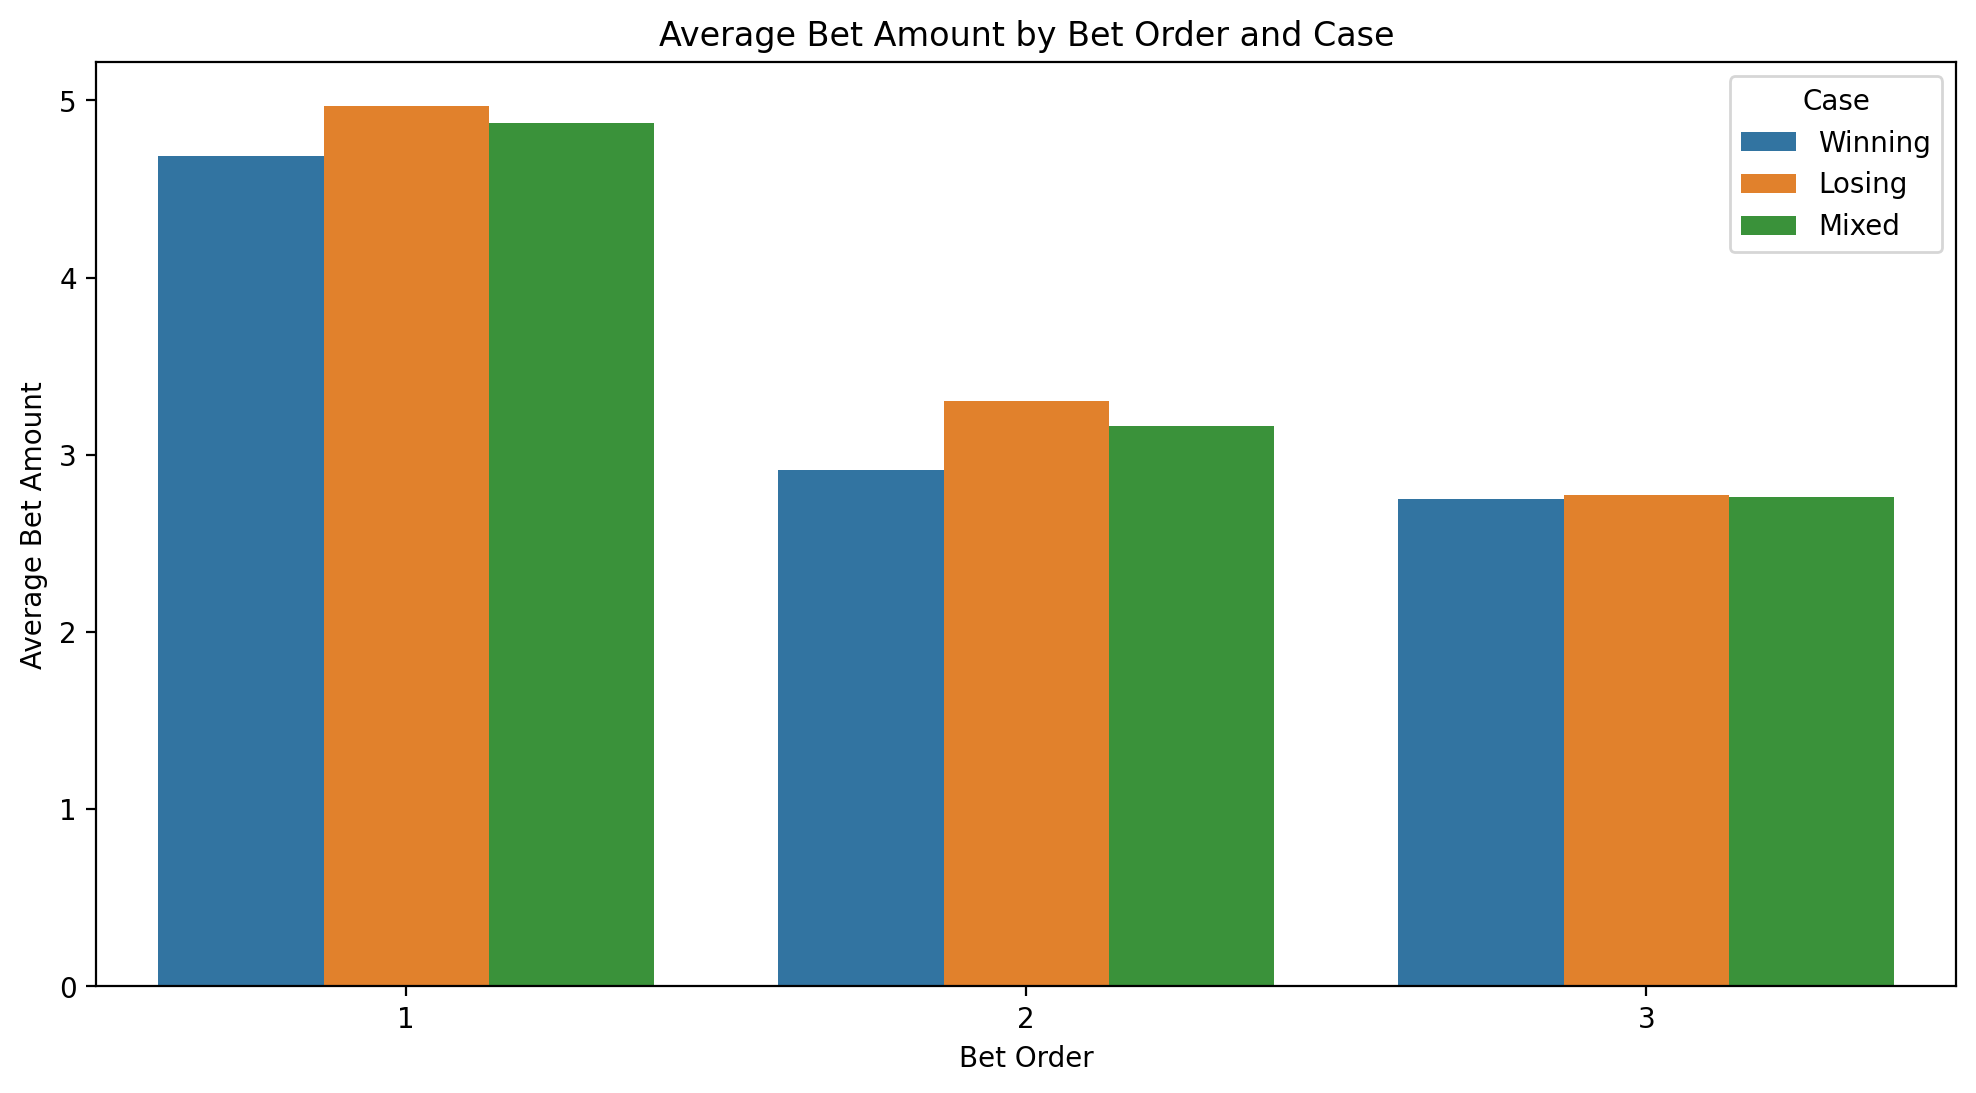

(bet_order
 1    4.684901
 2    2.913924
 3    2.752580
 Name: Bet amount, dtype: float64,
 bet_order
 1    4.965252
 2    3.303086
 3    2.770634
 Name: Bet amount, dtype: float64,
 bet_order
 1    4.873130
 2    3.159606
 3    2.763462
 Name: Bet amount, dtype: float64)

In [16]:
import numpy as np
import seaborn as sns

# 1. Winning Cases: Users who only win in a row
winning_cases = data[data['Result'] == 1]
average_bet_win = winning_cases.groupby('bet_order')['Bet amount'].mean()

# 2. Losing Cases: Users who lose
losing_cases = data[data['Result'] == 0]
average_bet_lose = losing_cases.groupby('bet_order')['Bet amount'].mean()

# 3. Average/Mixed: General trend across all users
average_bet_mixed = data.groupby('bet_order')['Bet amount'].mean()

# Adjusting the approach to handle missing data in bet orders

# Fill missing bet orders with zeros for consistent lengths
average_bet_win = average_bet_win.reindex([1, 2, 3], fill_value=0)
average_bet_lose = average_bet_lose.reindex([1, 2, 3], fill_value=0)
average_bet_mixed = average_bet_mixed.reindex([1, 2, 3], fill_value=0)

# Creating a DataFrame for visualization
bet_amounts_df = pd.DataFrame({
    'Bet Order': np.tile(np.arange(1, 4), 3),
    'Average Bet Amount': np.concatenate([average_bet_win.values, average_bet_lose.values, average_bet_mixed.values]),
    'Case': ['Winning'] * 3 + ['Losing'] * 3 + ['Mixed'] * 3
})

# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(x='Bet Order', y='Average Bet Amount', hue='Case', data=bet_amounts_df)
plt.title('Average Bet Amount by Bet Order and Case')
plt.xlabel('Bet Order')
plt.ylabel('Average Bet Amount')
plt.show()

# Return average bet amounts for analysis
average_bet_win, average_bet_lose, average_bet_mixed


In [17]:
# Return average bet amounts for analysis
average_bet_win, average_bet_lose, average_bet_mixed

(bet_order
 1    4.684901
 2    2.913924
 3    2.752580
 Name: Bet amount, dtype: float64,
 bet_order
 1    4.965252
 2    3.303086
 3    2.770634
 Name: Bet amount, dtype: float64,
 bet_order
 1    4.873130
 2    3.159606
 3    2.763462
 Name: Bet amount, dtype: float64)

<Figure size 1600x800 with 0 Axes>

<Axes: xlabel='bet_order'>

Text(0.5, 1.0, 'Average Bet Amount for Winning Cases')

Text(0.5, 0, 'Bet Order')

Text(0, 0.5, 'Average Bet Amount')

(0.0, 5.965251764705882)

<Figure size 1600x800 with 0 Axes>

<Axes: xlabel='bet_order'>

Text(0.5, 1.0, 'Average Bet Amount for Losing Cases')

Text(0.5, 0, 'Bet Order')

Text(0, 0.5, 'Average Bet Amount')

(0.0, 5.965251764705882)

<Figure size 1600x800 with 0 Axes>

<Axes: xlabel='bet_order'>

Text(0.5, 1.0, 'Average Bet Amount for Average/Mixed Cases')

Text(0.5, 0, 'Bet Order')

Text(0, 0.5, 'Average Bet Amount')

(0.0, 5.965251764705882)

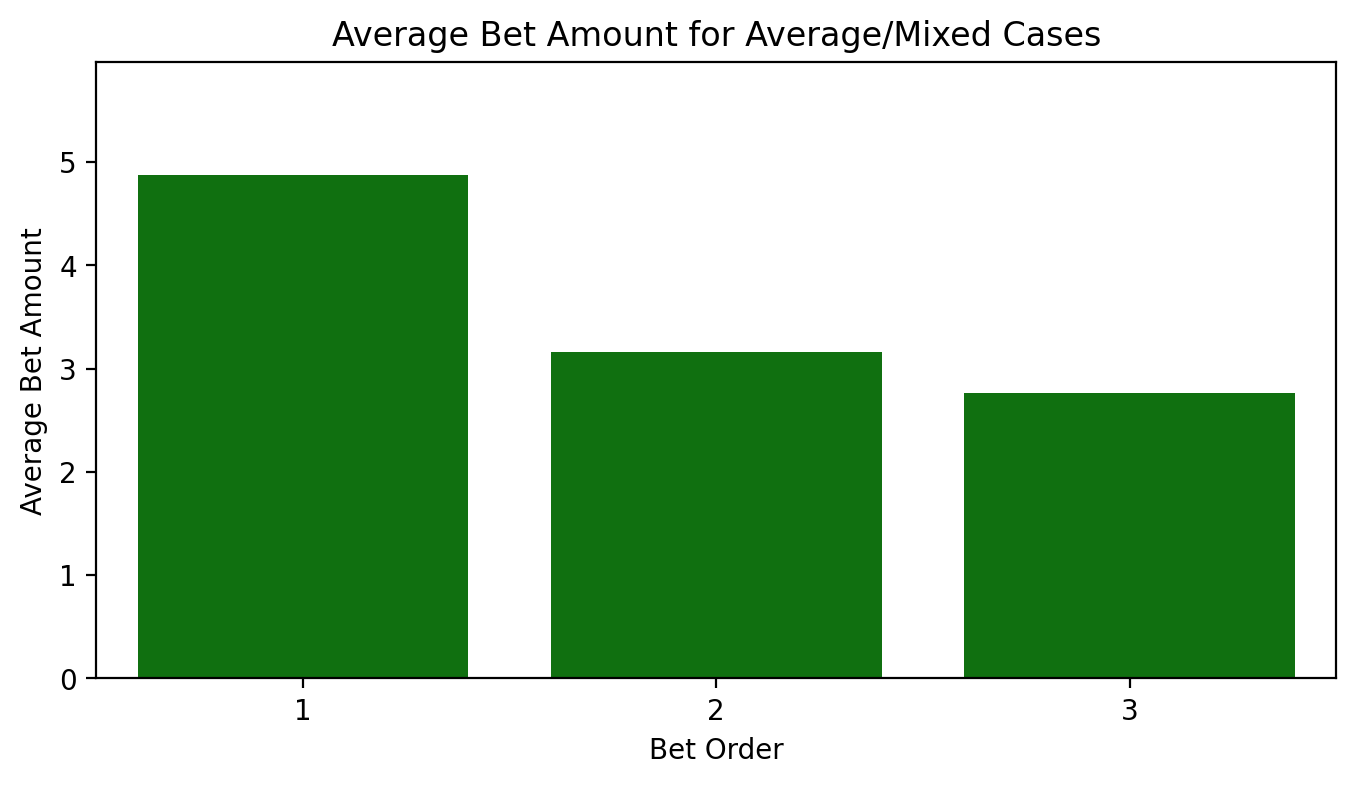

In [18]:
# Plotting separate graphs for each scenario

# Winning Cases
plt.figure(figsize=(8, 4))
sns.barplot(x=average_bet_win.index, y=average_bet_win.values)
plt.title('Average Bet Amount for Winning Cases')
plt.xlabel('Bet Order')
plt.ylabel('Average Bet Amount')
plt.ylim(0, max(average_bet_win.max(), average_bet_lose.max(), average_bet_mixed.max()) + 1)
plt.show()

# Losing Cases
plt.figure(figsize=(8, 4))
sns.barplot(x=average_bet_lose.index, y=average_bet_lose.values, color='orange')
plt.title('Average Bet Amount for Losing Cases')
plt.xlabel('Bet Order')
plt.ylabel('Average Bet Amount')
plt.ylim(0, max(average_bet_win.max(), average_bet_lose.max(), average_bet_mixed.max()) + 1)
plt.show()

# Average/Mixed Cases
plt.figure(figsize=(8, 4))
sns.barplot(x=average_bet_mixed.index, y=average_bet_mixed.values, color='green')
plt.title('Average Bet Amount for Average/Mixed Cases')
plt.xlabel('Bet Order')
plt.ylabel('Average Bet Amount')
plt.ylim(0, max(average_bet_win.max(), average_bet_lose.max(), average_bet_mixed.max()) + 1)
plt.show()


In [ ]:
# Winning Cases (Blue Bars):
# Bet Order 1: Average bet amount is approximately $4.68.
# Bet Order 2: Average bet amount decreases to about $2.91.
# Bet Order 3: Further decrease to around $2.75.
# In winning cases, users tend to decrease their bet amounts as they progress from bet 1 to bet 3.

# Losing Cases (Orange Bars):
# Bet Order 1: Average bet amount is approximately $4.97.
# Bet Order 2: Average bet amount decreases to about $3.30.
# Bet Order 3: Slightly decreases to around $2.77.
# Similar to winning cases, in losing scenarios, users also tend to decrease their bet amounts over successive bets.

# Average/Mixed Cases (Green Bars):
# Bet Order 1: Average bet amount is approximately $4.87.
# Bet Order 2: Average bet amount decreases to about $3.16.
# Bet Order 3: A small decrease to around $2.76.
# Across all users, there's a general trend of decreasing bet amounts from bet 1 to bet 3.
# Conclusion
# In all three scenarios (winning, losing, and mixed), users tend to decrease their bet amounts as they progress 
# from bet 1 to bet 3. This indicates a cautious approach to betting, where users are likely adjusting their bets based on their experiences in previous rounds, regardless of whether they win or lose. ​​

In [19]:
dt = consecutive_wins_per_user.groupby("Max_Consecutive_Wins").agg(
    {"User_id": "count"}
).reset_index()
dt = dt.rename(columns={"User_id": "total_users"})
dt["share"] = dt["total_users"] / dt["total_users"].sum()
dt
# dt.to_clipboard(index=False)

Max_Consecutive_Wins  total_users     share
0                     0         6269  0.495182
1                     1         4231  0.334202
2                     2         1223  0.096603
3                     3          575  0.045419
4                     4          212  0.016746
5                     5          116  0.009163
6                     6           23  0.001817
7                     7            6  0.000474
8                     8            4  0.000316
9                     9            1  0.000079

In [20]:
fig = px.histogram(
    consecutive_wins_per_user,
    x="Max_Consecutive_Wins",
    marginal="box",
    nbins=20,
    title="Distribution of Max Consecutive Wins per User",
    histnorm="probability",
    cumulative=False,
)

fig.update_layout(
    xaxis=dict(
        tickmode='linear',
        tick0=0,
        dtick=1
    )
)



In [21]:
fig = px.histogram(
    consecutive_wins_per_user_daily,
    x="Max_Consecutive_Wins",
    marginal="box",
    nbins=20,
    title="Distribution of Max Consecutive Wins per User",
)

fig.update_layout(
    xaxis=dict(
        tickmode='linear',
        tick0=0,
        dtick=1
    )
)


## Distibutions

In [22]:
# Analyzing the data for consecutive win probabilities and bet amount distribution

# 1. Calculate Probabilities for Consecutive Wins
# Assumption: The dataset is ordered chronologically for each user
# We will check for consecutive wins for each user

# Grouping the data by User_id and sorting by Datetime
grouped_data = data.sort_values(by=['User_id', 'Datetime']).groupby('User_id')

# Initializing counters for consecutive wins
first_win_count = 0
second_win_count = 0
third_win_count = 0
total_rounds_count = 0

# Function to count consecutive wins
def count_consecutive_wins(group):
    global first_win_count, second_win_count, third_win_count, total_rounds_count
    consecutive_wins = 0

    for index, row in group.iterrows():
        total_rounds_count += 1
        if row['Result'] == 1:  # Win
            consecutive_wins += 1
            if consecutive_wins == 1:
                first_win_count += 1
            elif consecutive_wins == 2:
                second_win_count += 1
            elif consecutive_wins >= 3:
                third_win_count += 1
        else:  # Loss resets the consecutive win count
            consecutive_wins = 0

# Apply the function to each group
grouped_data.apply(count_consecutive_wins)

# Calculating probabilities
prob_first_win = first_win_count / total_rounds_count
prob_second_win = second_win_count / total_rounds_count
prob_third_win = third_win_count / total_rounds_count

# 2. Analyze Bet Amount Distribution
# We will create bins for the bet amounts

# Finding the range of bet amounts
min_bet = data['Bet amount'].min()
max_bet = data['Bet amount'].max()

# Creating bins for bet amounts
bet_amount_bins = np.linspace(min_bet, max_bet, 5)  # Creating 5 bins as an example

# Counting the number of bets in each bin
bet_amount_distribution = pd.cut(data['Bet amount'], bet_amount_bins).value_counts()

prob_first_win, prob_second_win, prob_third_win, bet_amount_bins, bet_amount_distribution


Empty DataFrame
Columns: []
Index: []

(0.24490744653875413,
 0.07697996788099062,
 0.04798833572817175,
 array([  0.39  ,  25.2925,  50.195 ,  75.0975, 100.    ]),
 Bet amount
 (0.39, 25.292]      46650
 (25.292, 50.195]       81
 (75.098, 100.0]        37
 (50.195, 75.098]        4
 Name: count, dtype: int64)

In [29]:
bettting_probabilities = (
    data.groupby(["bet_order"])
    .agg(
        {
            "User_id": "nunique",
            "Result": "mean",
            "Round_id": "nunique",
            "Reward": "sum",
            "Bet amount": "sum",
        }
    )
    .reset_index()
)

bettting_probabilities = bettting_probabilities.rename(
    columns={
        "User_id": "unique_users",
        "Result": "win_probability",
        "Round_id": "unique_rounds",
        "Reward": "total_reward",
        "Bet amount": "total_bet_amount",
    }
)
bettting_probabilities = bettting_probabilities.sort_values(by=["bet_order"])
bettting_probabilities["win_rate_monetary"] = (
    bettting_probabilities["total_reward"] / bettting_probabilities["total_bet_amount"]
)
# bettting_probabilities['ROI'] = bettting_probabilities['win_rate_monetary'] - 1
bettting_probabilities.head()

bet_order  unique_users  win_probability  unique_rounds  total_reward  \
0        1.0         12660         0.328594          12660      29233.90   
1        2.0          6241         0.368691           6241      10058.25   
2        3.0          3952         0.397267           3952       6482.39   
3        4.0          2794         0.403006           2794       4693.16   
4        5.0          2103         0.408464           2103       3544.71   

   total_bet_amount  win_rate_monetary  
0          61693.83           0.473855  
1          19719.10           0.510077  
2          10921.20           0.593560  
3           7432.40           0.631446  
4           5497.46           0.644791

In [66]:
bets_distribution= data.groupby(["Bet amount"]).agg({"User_id": "nunique"})
bets_distribution = bets_distribution.rename(columns={"User_id": "unique_users"}).reset_index()
bets_distribution.head()

Bet amount  unique_users
0        0.39           161
1        0.40            67
2        0.41             2
3        0.42            22
4        0.43            16

<Figure size 2400x1200 with 0 Axes>

<Axes: xlabel='Bet Change 1 to 2', ylabel='Count'>

Text(0.5, 1.0, 'Bet Change Behavior from 1st Round to 2nd Round After Wins and Losses')

Text(0.5, 0, 'Bet Change from 1st to 2nd Round')

Text(0, 0.5, 'Count')

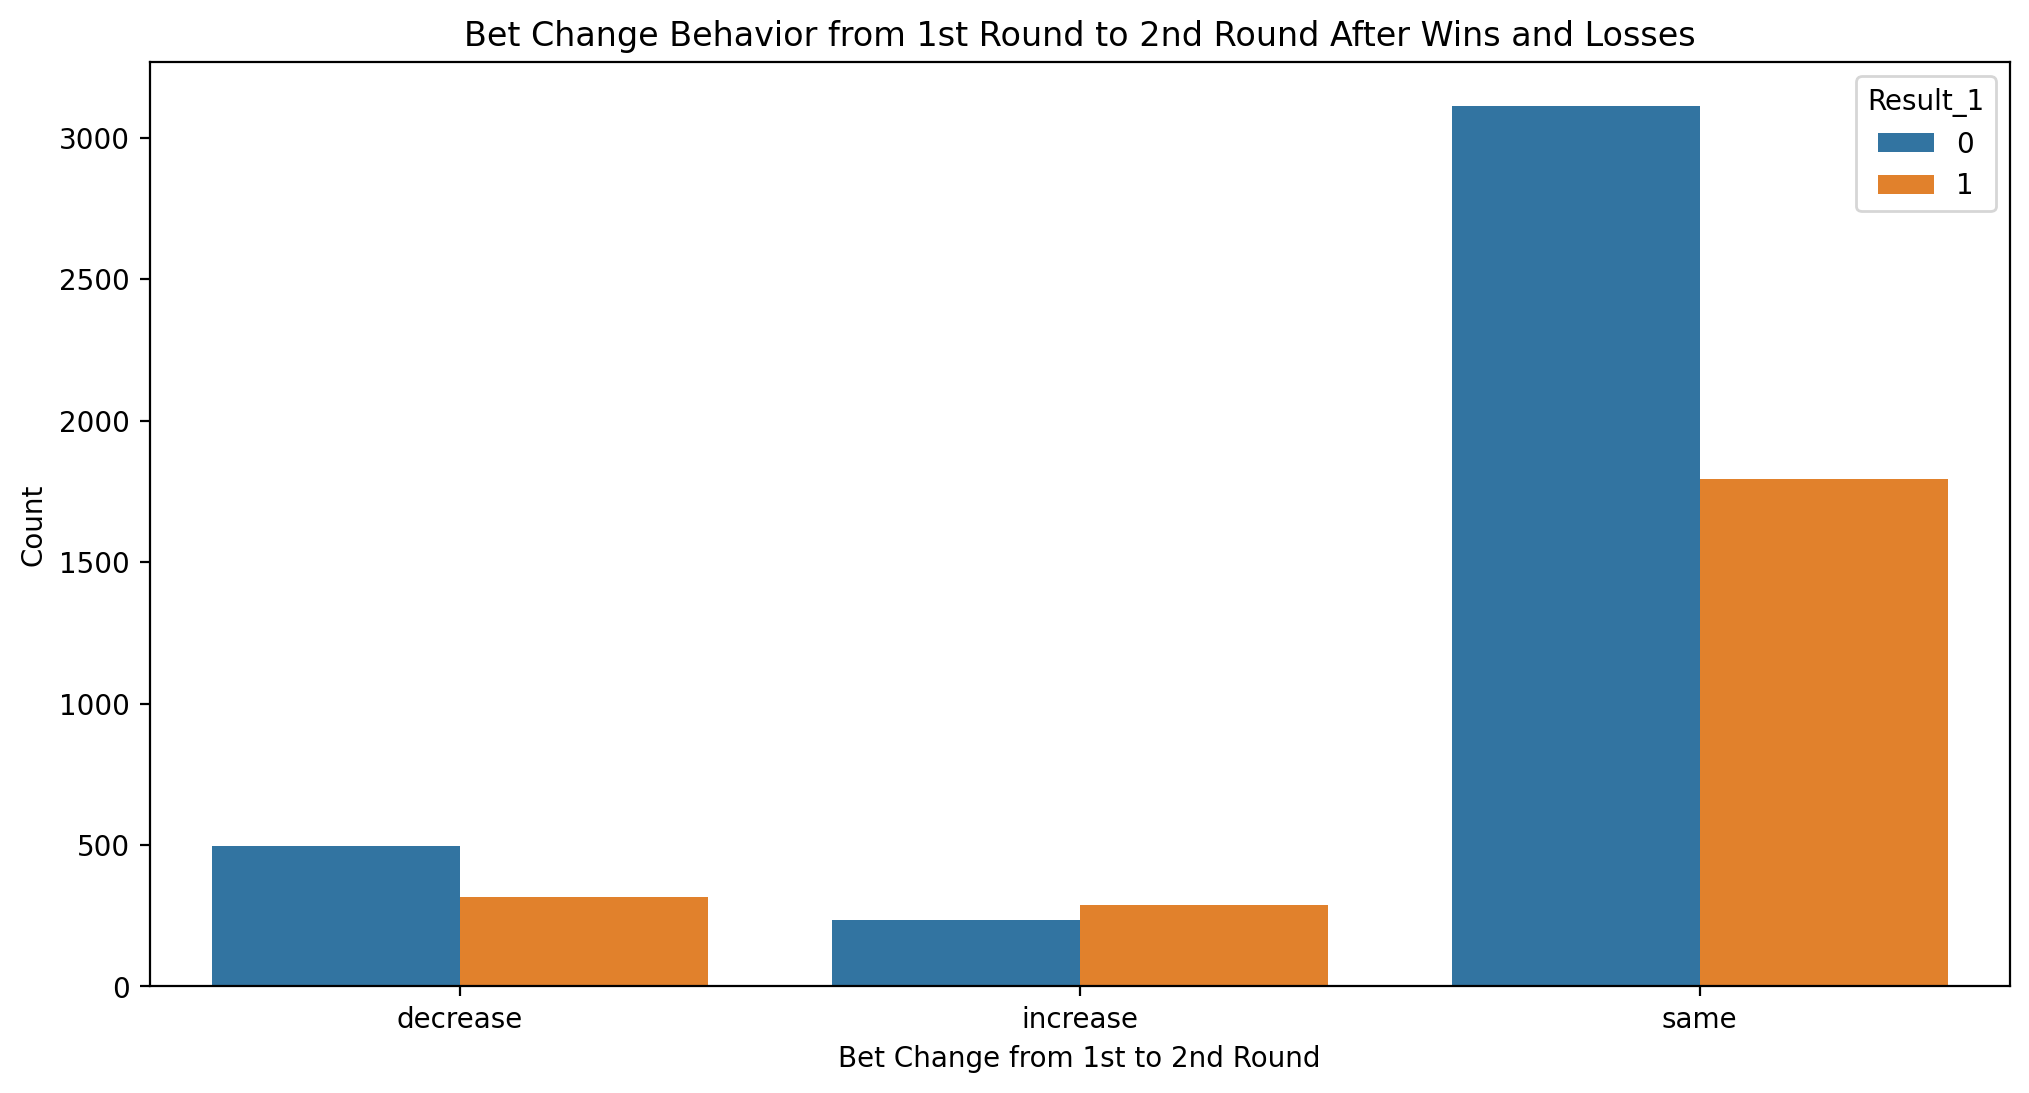

Result_1                0       1
Bet Change 1 to 2                
decrease            497.0   316.0
increase            236.0   287.0
same               3111.0  1794.0

In [68]:
data_sorted = data.sort_values(by=['User_id', 'Datetime'])
data_sorted['Next Result'] = data_sorted.groupby('User_id')['Result'].shift(-1)

# Adding a column for the next round's bet amount
data_sorted['Next Bet Amount'] = data_sorted.groupby('User_id')['Bet amount'].shift(-1)

# Function to categorize bet changes
def categorize_bet_change(current_bet, next_bet):
    if next_bet > current_bet:
        return 'increase'
    elif next_bet < current_bet:
        return 'decrease'
    else:
        return 'same'

# Applying the function to each row
data_sorted['Bet Change'] = data_sorted.apply(lambda row: categorize_bet_change(row['Bet amount'], row['Next Bet Amount']), axis=1)

# Analyzing bet changes based on win or loss
bet_change_patterns = data_sorted.groupby(['Result', 'Bet Change']).size().unstack(fill_value=0)

# Normalizing the counts to get probabilities
bet_change_probabilities = bet_change_patterns.div(bet_change_patterns.sum(axis=1), axis=0)

# Adding a column to indicate the round number for each player
data_sorted['Round Number'] = data_sorted.groupby('User_id').cumcount() + 1

# Filtering data to include only the first and second rounds
data_first_two_rounds = data_sorted[data_sorted['Round Number'] <= 2]

# Identifying the first and second rounds for each player
first_rounds = data_first_two_rounds[data_first_two_rounds['Round Number'] == 1]
second_rounds = data_first_two_rounds[data_first_two_rounds['Round Number'] == 2]

# Merging first and second rounds on User_id
merged_rounds = first_rounds.merge(second_rounds, on='User_id', suffixes=('_1', '_2'))

# Categorizing bet changes from the first to the second round
merged_rounds['Bet Change 1 to 2'] = merged_rounds.apply(lambda row: categorize_bet_change(row['Bet amount_1'], row['Bet amount_2']), axis=1)

# Counting the occurrences of each bet change category
bet_change_counts_1_to_2 = merged_rounds.groupby(['Result_1', 'Bet Change 1 to 2']).size().reset_index(name='Count')

# Creating pivot table for visualization
bet_change_pivot_1_to_2 = bet_change_counts_1_to_2.pivot_table(index='Bet Change 1 to 2', columns='Result_1', values='Count', fill_value=0)

# Visualizing the transition from the 1st round to the 2nd round
plt.figure(figsize=(12, 6))
sns.barplot(x='Bet Change 1 to 2', y='Count', hue='Result_1', data=bet_change_counts_1_to_2)
plt.title('Bet Change Behavior from 1st Round to 2nd Round After Wins and Losses')
plt.xlabel('Bet Change from 1st to 2nd Round')
plt.ylabel('Count')
plt.show()

bet_change_pivot_1_to_2



In [67]:
# Identifying sequences of three consecutive wins for each player
# We need to group by User_id and count the sequences of three consecutive wins

# Adding a column to indicate if a round is a win (1) or not (0)
data_sorted['Win'] = data_sorted['Result'] == 1

# Creating a rolling window of 3 rounds to check for three consecutive wins
data_sorted['Three Consecutive Wins'] = data_sorted.groupby('User_id')['Win'].rolling(window=3).sum().reset_index(level=0, drop=True)

# Counting the instances of three consecutive wins
three_consecutive_wins_count = data_sorted[data_sorted['Three Consecutive Wins'] == 3].shape[0]

# Total number of sequences of three rounds (subtracting the last two rounds for each player as they cannot form a sequence of three)
total_sequences_of_three = data_sorted.groupby('User_id').size().sum() - 2 * data_sorted['User_id'].nunique()

# Calculating the probability of winning three rounds in a row
probability_of_winning_3_consecutive = three_consecutive_wins_count / total_sequences_of_three
probability_of_winning_3_consecutive

0.1032085075440829

In [55]:
from datetime import datetime, timedelta

# Filtering data for players who won three consecutive rounds
winning_streaks = data_sorted[data_sorted['Three Consecutive Wins'] == 3]

# 1. Average Bet Amounts for First, Second, and Third Rounds
average_first_bet = winning_streaks.groupby('User_id')['Bet amount'].nth(0).mean()
average_second_bet = winning_streaks.groupby('User_id')['Bet amount'].nth(1).mean()
average_third_bet = winning_streaks.groupby('User_id')['Bet amount'].nth(2).mean()

# 2. Average Rewards/Payouts per Round and Total
# Assuming reward is calculated as bet amount times multiplier
# Using multipliers: 1.5 for first win, 2 for second win, and 10 for third win
average_reward_first_round = average_first_bet * 1.5
average_reward_second_round = average_second_bet * 2
average_reward_third_round = average_third_bet * 10
average_total_reward = average_reward_first_round + average_reward_second_round + average_reward_third_round

# 3. Timing of Bets - Day of the Week and Time of Day
winning_streaks['Datetime'] = pd.to_datetime(winning_streaks['Datetime'])
average_day_of_week = winning_streaks['Datetime'].dt.day_name().mode()[0]  # Most common day of the week
average_time_of_day = winning_streaks['Datetime'].dt.hour.mode()[0]  # Most common hour of the day

# 4. Duration of the Streak
# Calculating the time difference between the first and third wins
time_differences = winning_streaks.groupby('User_id')['Datetime'].agg(lambda x: max(x) - min(x))
average_duration = time_differences.mean()

(average_first_bet, average_second_bet, average_third_bet,
 average_reward_first_round, average_reward_second_round, average_reward_third_round, average_total_reward,
 average_day_of_week, average_time_of_day, average_duration)



/var/folders/6y/p69wgs_n4cn8pyp7ly6k1f6m0000gn/T/ipykernel_30652/1605277524.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(2.960896478121665,
 2.843374689826303,
 2.7514572864321605,
 4.441344717182497,
 5.686749379652606,
 27.514572864321604,
 37.642666961156706,
 'Saturday',
 19,
 Timedelta('1 days 22:30:58.429908036'))

In [39]:
# Converting the bet options from strings to lists of integers for easier processing
bet_structure_converted = {
    3: [[3, 5, 10], [3, 5, 10], [3, 5, 10], 1.5, 2, 10],
    5: [[5, 10, 15], [5, 10, 15], [5, 10, 15], 1.5, 2, 10],
    10: [[10, 15, 20], [10, 15, 20], [10, 15, 20], 1.5, 2, 10],
    15: [[15, 20, 30], [15, 20, 30], [15, 20, 30], 1.5, 2, 10],
    20: [[20, 30, 50], [20, 30, 50], [20, 30, 50], 1.5, 2, 10],
    30: [[30, 50], [30, 50], [30, 50], 1.5, 2, 10],
    50: [[50, 100], [50, 100], [50, 100], 1.5, 2, 10],
    100: [[100], [100], [100], 1.5, 2, 10]
}

def simulate_betting_with_updated_structure(initial_bet):
    """
    Simulates the betting process with multipliers, allowing bet changes for each round based on the updated bet structure.

    Args:
    initial_bet (int): The initial bet amount placed by the player.

    Returns:
    dict: A dictionary showing the bet amounts, winnings, and potential bet options for each of the three rounds.
    """
    if initial_bet not in bet_structure_converted:
        return "Invalid initial bet amount."

    # Initialize rounds
    rounds = {
        "Round 1": {"Bet": initial_bet, "Options": bet_structure_converted[initial_bet][0]},
        "Round 2": {"Bet": initial_bet, "Options": bet_structure_converted[initial_bet][1]},
        "Round 3": {"Bet": initial_bet, "Options": bet_structure_converted[initial_bet][2]}
    }

    # Simulate each round
    for i, round in enumerate(rounds, start=1):
        # Apply multiplier
        multiplier = bet_structure_converted[initial_bet][i + 2]
        bet = rounds[round]["Bet"]
        rounds[round]["Winnings"] = bet * multiplier

    return rounds

# Example: Simulating the betting process with an initial bet of $10
simulate_betting_with_updated_structure(10)



{'Round 1': {'Bet': 10, 'Options': [10, 15, 20], 'Winnings': 15.0},
 'Round 2': {'Bet': 10, 'Options': [10, 15, 20], 'Winnings': 20},
 'Round 3': {'Bet': 10, 'Options': [10, 15, 20], 'Winnings': 100}}

In [40]:
# Revisiting the distribution of bet amounts from the dataset
import random

bet_amounts_distribution = data['Bet amount'].value_counts(normalize=True)

# Randomly selecting a bet amount for the first round based on the distribution
random_bet = random.choices(population=bet_amounts_distribution.index, weights=bet_amounts_distribution.values, k=1)[0]

# Running the simulation with this randomly selected bet amount
simulation_result = simulate_betting_with_updated_structure(random_bet)
random_bet, simulation_result


(10.0,
 {'Round 1': {'Bet': 10.0, 'Options': [10, 15, 20], 'Winnings': 15.0},
  'Round 2': {'Bet': 10.0, 'Options': [10, 15, 20], 'Winnings': 20.0},
  'Round 3': {'Bet': 10.0, 'Options': [10, 15, 20], 'Winnings': 100.0}})

In [41]:
def map_and_estimate_probabilities(existing_distribution, new_bet_structure):
    """
    Maps bet amounts from the existing distribution to the new bet amounts and
    estimates their probabilities.

    Args:
    existing_distribution (pd.Series): The distribution of existing bet amounts.
    new_bet_structure (list): The list of new valid bet amounts.

    Returns:
    pd.Series: Estimated probabilities for each new bet amount.
    """
    # Mapping existing bet amounts to the nearest new bet amount
    def map_to_nearest_bet_amount(bet):
        return min(new_bet_structure, key=lambda x: abs(x - bet))

    mapped_bets = existing_distribution.index.map(map_to_nearest_bet_amount)

    # Creating a new DataFrame with mapped bets and their original probabilities
    mapped_bets_df = pd.DataFrame({'Mapped Bet': mapped_bets, 'Probability': existing_distribution.values})

    # Aggregating probabilities for each new bet amount
    aggregated_probabilities = mapped_bets_df.groupby('Mapped Bet')['Probability'].sum()

    return aggregated_probabilities

# Valid bet amounts as per the new bet structure
new_bet_amounts = list(bet_structure_converted.keys())

# Existing distribution from the dataset
existing_bet_distribution = data['Bet amount'].value_counts(normalize=True)

# Estimating the probabilities for the new bet amounts
estimated_probabilities = map_and_estimate_probabilities(existing_bet_distribution, new_bet_amounts)
estimated_probabilities



Mapped Bet
3      0.731574
5      0.083171
10     0.177627
15     0.000127
20     0.004924
30     0.000042
50     0.001754
100    0.000782
Name: Probability, dtype: float64

In [49]:
bets_distribution_per_rounds = data.pivot_table(
    index="User_id",
    columns="bet_order",
    values="Bet amount",
    aggfunc="mean",
    fill_value=0,
)
# bets_distribution_per_rounds = bets_distribution_per_rounds.rename(
#     columns={"User_id": "unique_users"}
# ).reset_index()
# bets_distribution_per_rounds.columns = [
#     "Bet amount",
#     "unique_users_round_1",
#     "unique_users_round_2",
#     "unique_users_round_3",
# ]

# bets_distribution_per_rounds.shape[1]
# bets_distribution_per_rounds.columns = [i for i in range(0, )]
bets_distribution_per_rounds = bets_distribution_per_rounds.iloc[:, 0:100]
bets_distribution_per_rounds.head()
 

bet_order  1.0    2.0    3.0    4.0    5.0    6.0    7.0    8.0    9.0    \
User_id                                                                    
118        10.00    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
129         1.00    0.5    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
146         9.99    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
194         8.44    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
435         0.50    0.5    0.5    0.5    0.5    0.0    0.0    0.0    0.0   

bet_order  10.0   11.0   12.0   13.0   14.0   15.0   16.0   17.0   18.0   \
User_id                                                                    
118          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
129          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
146          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
194          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
435          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

bet_order  19.0   20.0   21.0   22.0   23.0   24.0   25.0   26.0   27.0   \
User_id                                                                    
118          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
129          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
146          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
194          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
435          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

bet_order  28.0   29.0   30.0   31.0   32.0   33.0   34.0   35.0   36.0   \
User_id                                                                    
118          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
129          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
146          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
194          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
435          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

bet_order  37.0   38.0   39.0   40.0   41.0   42.0   43.0   44.0   45.0   \
User_id                                                                    
118          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
129          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
146          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
194          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
435          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

bet_order  46.0   47.0   48.0   49.0   50.0   51.0   52.0   53.0   54.0   \
User_id                                                                    
118          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
129          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
146          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
194          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
435          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

bet_order  55.0   56.0   57.0   58.0   59.0   60.0   61.0   62.0   63.0   \
User_id                                                                    
118          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
129          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
146          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
194          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
435          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

bet_order  64.0   65.0   66.0   67.0   68.0   69.0   70.0   71.0   72.0   \
User_id                                                                    
118          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
129          0.0    0.0    0.0    0.0    

In [34]:
px.histogram(
    data_frame=data,
    x="Bet amount",
    marginal="box",
    nbins=100,
    title="Distribution of Bet Amounts",
    histnorm="probability",
    cumulative=False,
)


## Cohorts

CohortIndexWeek            1      2     3     4     5     6     7     8   \
FirstActivityWeek                                                          
2023-10-09/2023-10-15  1366.0  102.0  75.0  66.0  66.0  50.0  43.0  41.0   
2023-10-16/2023-10-22  1455.0   93.0  63.0  60.0  54.0  46.0  51.0  38.0   
2023-10-23/2023-10-29  1329.0   77.0  55.0  56.0  42.0  38.0  35.0   NaN   
2023-10-30/2023-11-05  1269.0   74.0  60.0  39.0  56.0  29.0   6.0   NaN   
2023-11-06/2023-11-12  1361.0   70.0  48.0  42.0  43.0   3.0   NaN   NaN   

CohortIndexWeek          9    10  
FirstActivityWeek                 
2023-10-09/2023-10-15  44.0  3.0  
2023-10-16/2023-10-22   NaN  NaN  
2023-10-23/2023-10-29   NaN  NaN  
2023-10-30/2023-11-05   NaN  NaN  
2023-11-06/2023-11-12   NaN  NaN

<Figure size 3000x1600 with 0 Axes>

<Axes: xlabel='CohortIndexWeek', ylabel='FirstActivityWeek'>

Text(0.5, 1.0, 'Weekly User Retention Cohorts')

Text(0.5, 117.4444444444444, 'Weeks Since First Activity')

Text(316.44444444444446, 0.5, 'First Week of Activity')

<Axes: xlabel='CohortIndexWeek', ylabel='FirstActivityWeek'>

Text(0.5, 1.0, 'Weekly Retention - Winning Users')

Text(0.5, 117.4444444444444, 'Weeks Since First Activity')

Text(441.44444444444446, 0.5, 'First Week of Activity')

<Axes: xlabel='CohortIndexWeek', ylabel='FirstActivityWeek'>

Text(0.5, 1.0, 'Weekly Retention - Non-Winning Users')

Text(0.5, 117.4444444444444, 'Weeks Since First Activity')

Text(2132.353535353535, 0.5, 'First Week of Activity')

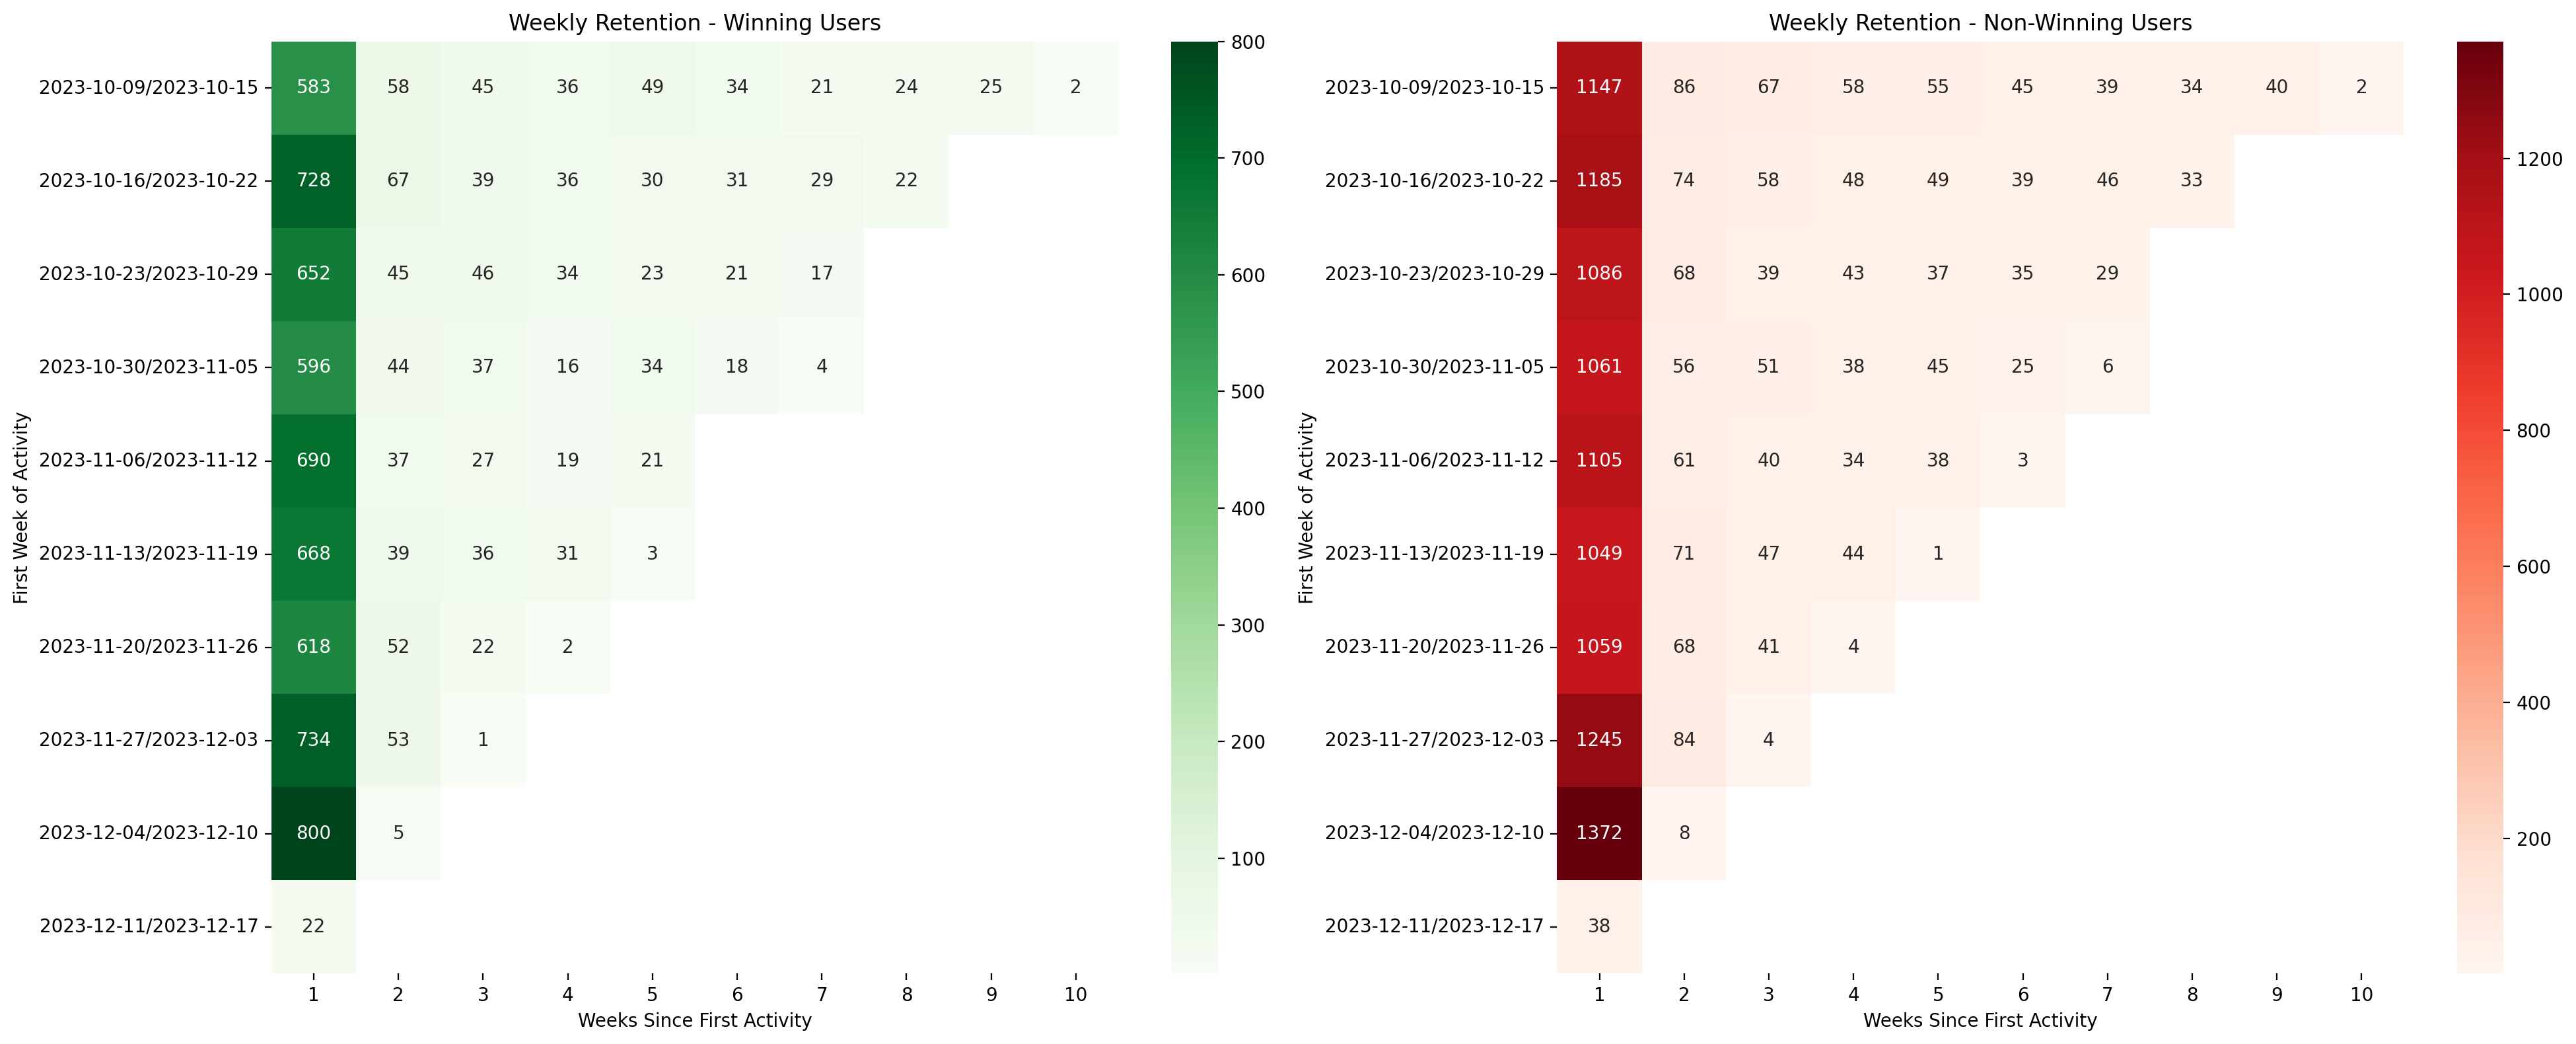

In [23]:
# Cohort Analysis on a Weekly Level

# Extracting the week from the 'Datetime' for cohort grouping
data["CohortWeek"] = data["Datetime"].dt.to_period("W")

# Identify the first week a user was active
cohort_week_data = data.groupby("User_id")["CohortWeek"].min().reset_index()
cohort_week_data.rename(columns={"CohortWeek": "FirstActivityWeek"}, inplace=True)

# Merge the cohort data with the original data
merged_week_data = pd.merge(data, cohort_week_data, on="User_id")

# Calculating time offsets - the number of weeks between each activity and the user's first activity
merged_week_data["CohortIndexWeek"] = (
    (
        merged_week_data["CohortWeek"].dt.year
        - merged_week_data["FirstActivityWeek"].dt.year
    )
    * 52
    + (
        merged_week_data["CohortWeek"].dt.week
        - merged_week_data["FirstActivityWeek"].dt.week
    )
    + 1
)

# Counting weekly active users from each cohort
grouped_week = merged_week_data.groupby(["FirstActivityWeek", "CohortIndexWeek"])
cohort_week_counts = grouped_week["User_id"].nunique().reset_index()

# Pivot the data for better readability
cohort_week_counts_pivot = cohort_week_counts.pivot(
    index="FirstActivityWeek", columns="CohortIndexWeek", values="User_id"
)

# Display the cohort analysis table on a weekly level
cohort_week_counts_pivot.head()

# First, let's create graphs for the cohort analysis on a weekly level
plt.figure(figsize=(15, 8))
sns.heatmap(cohort_week_counts_pivot, annot=True, fmt=".0f", cmap="Blues")
plt.title("Weekly User Retention Cohorts")
plt.xlabel("Weeks Since First Activity")
plt.ylabel("First Week of Activity")
plt.show()

# Now, let's compare cohorts between winning and non-winning users
# Winning users are those who have 'Result' as 1, and non-winning users have 'Result' as 0

# Creating separate dataframes for winning and non-winning users
winning_users = merged_week_data[merged_week_data["Result"] == 1]
non_winning_users = merged_week_data[merged_week_data["Result"] == 0]


# Function to calculate cohort retention
def calculate_cohort_retention(dataframe):
    grouped = dataframe.groupby(["FirstActivityWeek", "CohortIndexWeek"])
    cohort_counts = grouped["User_id"].nunique().reset_index()
    cohort_counts_pivot = cohort_counts.pivot(
        index="FirstActivityWeek", columns="CohortIndexWeek", values="User_id"
    )
    return cohort_counts_pivot


# Calculate cohort retention for winning and non-winning users
winning_cohorts = calculate_cohort_retention(winning_users)
non_winning_cohorts = calculate_cohort_retention(non_winning_users)

# Plotting the results
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

sns.heatmap(winning_cohorts, annot=True, fmt=".0f", cmap="Greens", ax=ax[0])
ax[0].set_title("Weekly Retention - Winning Users")
ax[0].set_xlabel("Weeks Since First Activity")
ax[0].set_ylabel("First Week of Activity")

sns.heatmap(non_winning_cohorts, annot=True, fmt=".0f", cmap="Reds", ax=ax[1])
ax[1].set_title("Weekly Retention - Non-Winning Users")
ax[1].set_xlabel("Weeks Since First Activity")
ax[1].set_ylabel("First Week of Activity")

plt.tight_layout()
plt.show()

In [ ]:
# def calculate_user_daily_stats(df):
#     """
#     Function to calculate user-level daily stats including bet amounts for consecutive wins,
#     total bets, rounds, wins, payouts, and potential payouts with multipliers.
#     """
#     # Resampling the data on a daily basis per user
#     daily_user_data = (
#         df.groupby([pd.Grouper(key="Datetime", freq="D"), "User_id"])
#         .agg(
#             {"Round_id": "count", "Bet amount": "sum", "Result": "sum", "Reward": "sum"}
#         )
#         .reset_index()
#     )

#     # Renaming columns for clarity
#     daily_user_data.rename(
#         columns={
#             "Round_id": "total_rounds",
#             "Bet amount": "total_bet",
#             "Result": "total_wins",
#             "Reward": "total_payout",
#         },
#         inplace=True,
#     )

#     # Calculating first, second, third win in a row bet amount, and what_if_multiplier_streak_win
#     for index, row in daily_user_data.iterrows():
#         # Filter the original dataframe for the current day and user
#         current_day_user_df = df[
#             (df["Datetime"].dt.date == row["Datetime"])
#             & (df["User_id"] == row["User_id"])
#         ]

#         # Calculate the win streaks
#         current_day_user_df["Win_Streak"] = (
#             current_day_user_df["Result"] == 1
#         ).cumsum() - (current_day_user_df["Result"] == 1).cumsum().where(
#             current_day_user_df["Result"] == 0
#         ).ffill().fillna(
#             0
#         )

#         # Multipliers for consecutive wins
#         multiplier_mapping = {1: 1.5, 2: 2, 3: 10}

#         # Initializing the values
#         row["first_win_bet_amount"] = 0
#         row["second_win_in_a_row_bet_amount"] = 0
#         row["third_win_in_a_row_bet_amount"] = 0
#         row["what_if_multiplier_streak_win"] = 0

#         # Iterating over the filtered data to find consecutive wins and calculate the potential payout with multipliers
#         for i, r in current_day_user_df.iterrows():
#             if r["Win_Streak"] == 1:
#                 row["first_win_bet_amount"] = r["Bet amount"]
#             elif r["Win_Streak"] == 2:
#                 row["second_win_in_a_row_bet_amount"] = r[
#                     "Bet amount"
#                 ] * multiplier_mapping.get(2, 1)
#             elif r["Win_Streak"] == 3:
#                 row["third_win_in_a_row_bet_amount"] = r[
#                     "Bet amount"
#                 ] * multiplier_mapping.get(3, 1)

#             # Adding to the potential payout with multipliers
#             row["what_if_multiplier_streak_win"] += r[
#                 "Bet amount"
#             ] * multiplier_mapping.get(r["Win_Streak"], 1)

#         # Update the row in the dataframe
#         daily_user_data.loc[index] = row

#     return daily_user_data


# # Apply the function to the dataframe and display the results
# daily_user_stats = calculate_user_daily_stats(data)


# def calculate_user_daily_stats(df):
#     """
#     Function to calculate user-level daily stats including bet amounts for consecutive wins,
#     total bets, rounds, wins, payouts, and potential payouts with multipliers.
#     """
#     # Resampling the data on a daily basis per user
#     daily_user_data = (
#         df.groupby([pd.Grouper(key="Datetime", freq="D"), "User_id"])
#         .agg(
#             {"Round_id": "count", "Bet amount": "sum", "Result": "sum", "Reward": "sum"}
#         )
#         .reset_index()
#     )

#     # Renaming columns for clarity
#     daily_user_data.rename(
#         columns={
#             "Round_id": "total_rounds",
#             "Bet amount": "total_bet",
#             "Result": "total_wins",
#             "Reward": "total_payout",
#         },
#         inplace=True,
#     )

#     # Calculating first, second, third win in a row bet amount, and what_if_multiplier_streak_win
#     for index, row in daily_user_data.iterrows():
#         # Filter the original dataframe for the current day and user
#         current_day_user_df = df[
#             (df["Datetime"].dt.date == row["Datetime"])
#             & (df["User_id"] == row["User_id"])
#         ]

#         # Calculate the win streaks
#         current_day_user_df["Win_Streak"] = (
#             current_day_user_df["Result"] == 1
#         ).cumsum() - (current_day_user_df["Result"] == 1).cumsum().where(
#             current_day_user_df["Result"] == 0
#         ).ffill().fillna(
#             0
#         )

#         # Multipliers for consecutive wins
#         multiplier_mapping = {1: 1.5, 2: 2, 3: 10}

#         # Initializing the values
#         row["first_win_bet_amount"] = 0
#         row["second_win_in_a_row_bet_amount"] = 0
#         row["third_win_in_a_row_bet_amount"] = 0
#         row["what_if_multiplier_streak_win"] = 0

#         # Iterating over the filtered data to find consecutive wins and calculate the potential payout with multipliers
#         for i, r in current_day_user_df.iterrows():
#             if r["Win_Streak"] == 1:
#                 row["first_win_bet_amount"] = r["Bet amount"]
#             elif r["Win_Streak"] == 2:
#                 row["second_win_in_a_row_bet_amount"] = r[
#                     "Bet amount"
#                 ] * multiplier_mapping.get(2, 1)
#             elif r["Win_Streak"] == 3:
#                 row["third_win_in_a_row_bet_amount"] = r[
#                     "Bet amount"
#                 ] * multiplier_mapping.get(3, 1)

#             # Adding to the potential payout with multipliers
#             row["what_if_multiplier_streak_win"] += r[
#                 "Bet amount"
#             ] * multiplier_mapping.get(r["Win_Streak"], 1)

#         # Update the row in the dataframe
#         daily_user_data.loc[index] = row

#     return daily_user_data


# # Apply the function to the dataframe and display the results
# daily_user_stats = calculate_user_daily_stats(data)

# Simulation

- 200 usrs
- average win on 3rd bet (±3 EUR)
bet 
- 10

In [24]:
import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats

## v1

In [25]:
# Redefining the bet structure to match exactly as per the original document

# Exact bet structure from the document
bet_structure = {
    "Bet Amount ($)": [3, 5, 10, 15, 20, 30, 50, 100],
    "Round 1 Bet Options ($)": ["3, 5, 10", "5, 10, 15", "10, 15, 20", "15, 20, 30", "20, 30, 50", "30, 50", "50, 100", "100"],
    "Round 2 Bet Options ($)": ["3, 5, 10", "5, 10, 15", "10, 15, 20", "15, 20, 30", "20, 30, 50", "30, 50", "50, 100", "100"],
    "Round 3 Bet Options ($)": ["3, 5, 10", "5, 10, 15", "10, 15, 20", "15, 20, 30", "20, 30, 50", "30, 50", "50, 100", "100"],
    "Multiplier for 1st Ball": [1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5],
    "Multiplier for 2nd Ball": [2, 2, 2, 2, 2, 2, 2, 2],
    "Multiplier for 3rd Ball": [10, 10, 10, 10, 10, 10, 10, 10]
}

# Creating a DataFrame for the exact bet structure table
exact_bet_table = pd.DataFrame(bet_structure)

exact_bet_table



def simulate_betting_process(initial_bet):
    """
    Simulates the betting process from the initial bet to the 3rd round,
    showing how the last bet carries over to the next round.

    Args:
    initial_bet (int): The initial bet amount placed by the player.

    Returns:
    dict: A dictionary showing the bet amounts for each of the three rounds.
    """
    # Check if the initial bet is in the proposed structure
    if initial_bet not in bet_structure:
        return "Invalid initial bet amount."

    # Round 1
    round_1_bet = initial_bet

    # Assuming the player does not change their bet, it carries over to the next rounds
    # Round 2 (Carry over from Round 1)
    round_2_bet = round_1_bet if round_1_bet in bet_structure[round_1_bet] else bet_structure[round_1_bet][0]

    # Round 3 (Carry over from Round 2)
    round_3_bet = round_2_bet if round_2_bet in bet_structure[round_2_bet] else bet_structure[round_2_bet][0]

    return {
        "Round 1 Bet ($)": round_1_bet,
        "Round 2 Bet ($)": round_2_bet,
        "Round 3 Bet ($)": round_3_bet
    }

# Example: Simulating the betting process with an initial bet of $10
simulate_betting_process(10)


Bet Amount ($) Round 1 Bet Options ($) Round 2 Bet Options ($)  \
0               3                3, 5, 10                3, 5, 10   
1               5               5, 10, 15               5, 10, 15   
2              10              10, 15, 20              10, 15, 20   
3              15              15, 20, 30              15, 20, 30   
4              20              20, 30, 50              20, 30, 50   
5              30                  30, 50                  30, 50   
6              50                 50, 100                 50, 100   
7             100                     100                     100   

  Round 3 Bet Options ($)  Multiplier for 1st Ball  Multiplier for 2nd Ball  \
0                3, 5, 10                      1.5                        2   
1               5, 10, 15                      1.5                        2   
2              10, 15, 20                      1.5                        2   
3              15, 20, 30                      1.5                        2   
4              20, 30, 50                      1.5                        2   
5                  30, 50                      1.5                        2   
6                 50, 100                      1.5                        2   
7                     100                      1.5                        2   

   Multiplier for 3rd Ball  
0                       10  
1                       10  
2                       10  
3                       10  
4                       10  
5                       10  
6                       10  
7                       10

'Invalid initial bet amount.'

## v2

In [26]:
import pandas as pd

# Define probabilities and multipliers
prob_1st_win = 0.33
prob_2nd_win = 0.095
prob_3rd_win = 0.045
multiplier_2nd_win = 1.5
multiplier_3rd_win = 2
multiplier_4th_win = 10

initial_bets = [3, 6, 9, 12, 15, 18, 21]
players_per_week = 1500

# Function to calculate expected return for a given bet and round
def expected_return(bet, round_num):
    if round_num == 1:
        return bet * prob_1st_win * multiplier_2nd_win
    elif round_num == 2:
        return bet * prob_2nd_win * multiplier_3rd_win
    elif round_num == 3:
        return bet * prob_3rd_win * multiplier_4th_win
    else:
        return 0

# Function to generate valid combinations (no skipping steps)
def generate_valid_combinations(initial_bet):
    possible_bets = [bet for bet in initial_bets if bet >= initial_bet]
    valid_combinations = []
    for bet_2 in possible_bets:
        for bet_3 in possible_bets:
            if (bet_2 in [initial_bet, initial_bet + 3] or bet_2 == 3) and (bet_3 in [bet_2, bet_2 + 3] or bet_3 == 3):
                valid_combinations.append((initial_bet, bet_2, bet_3))
    return valid_combinations

# Total expected return calculation
def total_expected_return(bets):
    total_return = 0
    if len(bets) >= 1:
        total_return += expected_return(bets[0], 1)
    if len(bets) >= 2 and bets[1] >= bets[0]:
        total_return += expected_return(bets[1], 2)
    if len(bets) == 3 and bets[2] >= bets[1]:
        total_return += expected_return(bets[2], 3)
    return total_return

# Simulation for no skipping steps
ggr_no_skip = []
for initial_bet in initial_bets:
    valid_combinations = generate_valid_combinations(initial_bet)
    max_return = 0
    best_combination = None
    for combo in valid_combinations:
        exp_return = total_expected_return(combo)
        if exp_return > max_return:
            max_return = exp_return
            best_combination = combo
    total_wagered = sum(best_combination) * players_per_week
    total_expected_winnings = max_return * players_per_week
    expected_ggr = total_wagered - total_expected_winnings
    ggr_no_skip.append({
        'Initial Bet': initial_bet,
        'Best Bet Combination': best_combination,
        'Total Wagered': total_wagered,
        'Total Expected Winnings': total_expected_winnings,
        'Expected GGR': expected_ggr
    })

# Simulation for fixed bet amounts
ggr_fixed_bet = []
for initial_bet in initial_bets:
    fixed_combination = (initial_bet, initial_bet, initial_bet)
    exp_return = total_expected_return(fixed_combination)
    total_wagered = sum(fixed_combination) * players_per_week
    total_expected_winnings = exp_return * players_per_week
    expected_ggr = total_wagered - total_expected_winnings
    ggr_fixed_bet.append({
        'Initial Bet': initial_bet,
        'Fixed Bet Combination': fixed_combination,
        'Total Wagered': total_wagered,
        'Total Expected Winnings': total_expected_winnings,
        'Expected GGR': expected_ggr
    })

# Convert to DataFrame
df_ggr_no_skip = pd.DataFrame(ggr_no_skip)
df_ggr_fixed_bet = pd.DataFrame(ggr_fixed_bet)

# Displaying results
print("GGR for No Skipping Steps Scenario:")
print(df_ggr_no_skip)
print("\nGGR for Fixed Bet Amounts Scenario:")
print(df_ggr_fixed_bet)

# Insights
print("\nInsights:")
print("1. The GGR increases with higher initial bets in both scenarios.")
print("2. Allowing step changes in bets tends to yield higher GGR, especially for lower initial bets.")
print("3. For the highest bet (21), the GGR is the same in both scenarios, indicating a fixed bet strategy is as effective as step changes for high bets.")

GGR for No Skipping Steps Scenario:
   Initial Bet Best Bet Combination  Total Wagered  Total Expected Winnings  \
0            3            (3, 6, 9)          27000                  10012.5   
1            6           (6, 9, 12)          40500                  15120.0   
2            9          (9, 12, 15)          54000                  20227.5   
3           12         (12, 15, 18)          67500                  25335.0   
4           15         (15, 18, 21)          81000                  30442.5   
5           18         (18, 21, 21)          90000                  33525.0   
6           21         (21, 21, 21)          94500                  35752.5   

   Expected GGR  
0       16987.5  
1       25380.0  
2       33772.5  
3       42165.0  
4       50557.5  
5       56475.0  
6       58747.5  

GGR for Fixed Bet Amounts Scenario:
   Initial Bet Fixed Bet Combination  Total Wagered  Total Expected Winnings  \
0            3             (3, 3, 3)          13500                   

In [27]:
import pandas as pd

# Define probabilities, multipliers, and initial bets
prob_1st_win = 0.33
prob_2nd_win = 0.095
prob_3rd_win = 0.045
multiplier_2nd_win = 1.5
multiplier_3rd_win = 2
multiplier_4th_win = 10
initial_bets = [3, 6, 9, 12, 15, 18, 21]
players_per_week = 1500

# Function to calculate expected return for a given bet and round
def expected_return(bet, round_num):
    if round_num == 1:
        return bet * prob_1st_win * multiplier_2nd_win
    elif round_num == 2:
        return bet * prob_2nd_win * multiplier_3rd_win
    elif round_num == 3:
        return bet * prob_3rd_win * multiplier_4th_win
    else:
        return 0

# Function to generate valid combinations (no skipping steps)
def generate_valid_combinations(initial_bet):
    possible_bets = [bet for bet in initial_bets if bet >= initial_bet]
    valid_combinations = []
    for bet_2 in possible_bets:
        for bet_3 in possible_bets:
            if (bet_2 in [initial_bet, initial_bet + 3] or bet_2 == 3) and (bet_3 in [bet_2, bet_2 + 3] or bet_3 == 3):
                valid_combinations.append((initial_bet, bet_2, bet_3))
    return valid_combinations

# Total expected return calculation
def total_expected_return(bets):
    total_return = 0
    if len(bets) >= 1:
        total_return += expected_return(bets[0], 1)
    if len(bets) >= 2 and bets[1] >= bets[0]:
        total_return += expected_return(bets[1], 2)
    if len(bets) == 3 and bets[2] >= bets[1]:
        total_return += expected_return(bets[2], 3)
    return total_return

# Calculate GGR for both scenarios
def calculate_ggr(scenario):
    ggr_results = []
    for initial_bet in initial_bets:
        if scenario == 'no_skip':
            valid_combinations = generate_valid_combinations(initial_bet)
        else:  # scenario == 'fixed_bet'
            valid_combinations = [(initial_bet, initial_bet, initial_bet)]
        
        max_return = 0
        best_combination = None
        for combo in valid_combinations:
            exp_return = total_expected_return(combo)
            if exp_return > max_return:
                max_return = exp_return
                best_combination = combo
        
        total_wagered = sum(best_combination) * players_per_week
        total_expected_winnings = max_return * players_per_week
        expected_ggr = total_wagered - total_expected_winnings

        ggr_results.append({
            'Initial Bet': initial_bet,
            'Expected GGR': expected_ggr
        })
    
    return pd.DataFrame(ggr_results)

# Generate DataFrames for both scenarios
df_ggr_no_skip = calculate_ggr('no_skip')
df_ggr_fixed_bet = calculate_ggr('fixed_bet')

# Merging the results for a comparative table
df_final_comparison = pd.merge(df_ggr_no_skip, df_ggr_fixed_bet, on='Initial Bet', suffixes=[' No Skip', ' Fixed Bet'])

# Displaying the final comparison table
print("Final GGR Comparison Table:")
print(df_final_comparison)

# Insights
print("\nInsights:")
print("1. The GGR tends to be higher in the 'No Skipping Steps' scenario for lower initial bets.")
print("2. For the highest initial bet (21), the GGR is comparable in both scenarios.")
print("3. Lower initial bets might benefit from flexible betting strategies, while higher bets can be fixed without impacting GGR.")


Final GGR Comparison Table:
   Initial Bet  Expected GGR No Skip  Expected GGR Fixed Bet
0            3               16987.5                  8392.5
1            6               25380.0                 16785.0
2            9               33772.5                 25177.5
3           12               42165.0                 33570.0
4           15               50557.5                 41962.5
5           18               56475.0                 50355.0
6           21               58747.5                 58747.5

Insights:
1. The GGR tends to be higher in the 'No Skipping Steps' scenario for lower initial bets.
2. For the highest initial bet (21), the GGR is comparable in both scenarios.
3. Lower initial bets might benefit from flexible betting strategies, while higher bets can be fixed without impacting GGR.


## v3

1. **Setup and Definitions**: The script starts by defining the probabilities of winning in each round, the multipliers for each win, the initial bet amounts, and the number of players per week.

2. **Calculate Round Details**: `calculate_round_details` function calculates the expected return and the number of winners for each round based on the bet amount and the round number.

3. **Generate Valid Combinations**: For the 'no skip' scenario, `generate_valid_combinations` generates all possible combinations of bets for the subsequent rounds, adhering to the rule of no skipping steps.

4. **Total Expected Details**: `total_expected_details` calculates the total expected return, total winners, and detailed winnings for each round for a given set of bets.

5. **Perform Simulation**: The `perform_simulation` function runs the simulation for both scenarios ('no skip' and 'fixed bet'). It calculates the expected GGR, total wagered amount, and winners in each round for each initial bet amount.

6. **Generate DataFrames and Display Results**: DataFrames for both scenarios are generated and printed, providing a detailed view of the outcomes for each scenario.

7. **Insights**: Finally, the script presents key insights derived from the simulations.


In [20]:
# # Define probabilities, multipliers, and initial bets
# prob_1st_win = 0.33
# prob_2nd_win = 0.095
# prob_3rd_win = 0.045
# multiplier_2nd_win = 1.5
# multiplier_3rd_win = 2
# multiplier_4th_win = 10
# initial_bets = [3, 6, 9, 12, 15, 18, 21]
# players_per_week = 1500

# # Function to calculate expected return and number of winners for a given bet and round
# def calculate_round_details(bet, round_num):
#     if round_num == 1:
#         win_prob = prob_1st_win
#     elif round_num == 2:
#         win_prob = prob_2nd_win
#     elif round_num == 3:
#         win_prob = prob_3rd_win
#     else:
#         return 0, 0

#     multiplier = [multiplier_2nd_win, multiplier_3rd_win, multiplier_4th_win][round_num - 1]
#     return bet * win_prob * multiplier, players_per_week * win_prob

# # Function to generate valid combinations (no skipping steps)
# def generate_valid_combinations(initial_bet):
#     possible_bets = [bet for bet in initial_bets if bet >= initial_bet]
#     valid_combinations = []
#     for bet_2 in possible_bets:
#         for bet_3 in possible_bets:
#             if (bet_2 in [initial_bet, initial_bet + 3] or bet_2 == 3) and (bet_3 in [bet_2, bet_2 + 3] or bet_3 == 3):
#                 valid_combinations.append((initial_bet, bet_2, bet_3))
#     return valid_combinations

# # Total expected return and winnings calculation
# def total_expected_details(bets):
#     total_return = 0
#     total_winners = players_per_week
#     round_winnings = []
#     for i, bet in enumerate(bets, start=1):
#         round_return, round_winners = calculate_round_details(bet, i)
#         total_return += round_return
#         total_winners *= (round_winners / players_per_week)
#         round_winnings.append((round_return, round_winners))
#     return total_return, total_winners, round_winnings

# # Simulation function (used for both scenarios)
# def perform_simulation(scenario):
#     ggr_results = []
#     for initial_bet in initial_bets:
#         if scenario == 'no_skip':
#             valid_combinations = generate_valid_combinations(initial_bet)
#         else:  # scenario == 'fixed_bet'
#             valid_combinations = [(initial_bet, initial_bet, initial_bet)]

#         max_return = 0
#         best_combination = None
#         best_round_details = None
#         for combo in valid_combinations:
#             exp_return, total_winners, round_winnings = total_expected_details(combo)
#             if exp_return > max_return:
#                 max_return = exp_return
#                 best_combination = combo
#                 best_round_details = round_winnings

#         total_wagered = sum(best_combination) * players_per_week
#         expected_ggr = total_wagered - max_return
#         ggr_results.append({
#             'Initial Bet': initial_bet,
#             'Combination': best_combination,
#             'Total Wagered': total_wagered,
#             'Total Expected Winnings': max_return,
#             'Expected GGR': expected_ggr,
#             'Winners in Round 1': best_round_details[0][1],
#             'Winners in Round 2': best_round_details[1][1],
#             'Winners in Round 3': best_round_details[2][1]
#         })
    
#     return pd.DataFrame(ggr_results)

# # Generate DataFrames for both scenarios
# df_ggr_no_skip = perform_simulation('no_skip')
# df_ggr_fixed_bet = perform_simulation('fixed_bet')

# # Displaying results
# print("GGR for No Skipping Steps Scenario:")
# print(df_ggr_no_skip.head())
# print("\nGGR for Fixed Bet Amounts Scenario:")
# print(df_ggr_fixed_bet.head())

# # Insights
# print("\nInsights:")
# print("1. The GGR increases with higher initial bets in both scenarios.")
# print("2. Allowing step changes in bets tends to yield higher GGR, especially for lower initial bets.")
# print("3. For the highest bet (21), the GGR is the same in both scenarios, indicating a fixed bet strategy is as effective as step changes for high bets.")

# # Define probabilities, multipliers, and initial bets
# prob_1st_win = 0.33
# prob_2nd_win = 0.095
# prob_3rd_win = 0.045

# multiplier_2nd_win = 1.5
# multiplier_3rd_win = 2
# multiplier_4th_win = 10
# initial_bets = [3, 6, 9, 12, 15, 18, 21]
# players_per_week = 1500

# # Function to calculate expected return and number of winners for a given bet and round
# def calculate_round_details(bet, round_num):
#     if round_num == 1:
#         win_prob = prob_1st_win
#     elif round_num == 2:
#         win_prob = prob_2nd_win
#     elif round_num == 3:
#         win_prob = prob_3rd_win
#     else:
#         return 0, 0

#     multiplier = [multiplier_2nd_win, multiplier_3rd_win, multiplier_4th_win][round_num - 1]
#     return bet * win_prob * multiplier, players_per_week * win_prob

# # Function to generate valid combinations (no skipping steps)
# def generate_valid_combinations(initial_bet):
#     possible_bets = [bet for bet in initial_bets if bet >= initial_bet]
#     valid_combinations = []
#     for bet_2 in possible_bets:
#         for bet_3 in possible_bets:
#             if (bet_2 in [initial_bet, initial_bet + 3] or bet_2 == 3) and (bet_3 in [bet_2, bet_2 + 3] or bet_3 == 3):
#                 valid_combinations.append((initial_bet, bet_2, bet_3))
#     return valid_combinations

# # Adjusted total expected return and winnings calculation
# def total_expected_details(bets):
#     total_winners = players_per_week
#     total_wagered = 0
#     total_expected_winnings = 0
#     for i, bet in enumerate(bets, start=1):
#         round_expected_winnings, round_winners = calculate_round_details(bet, i)
#         total_winners *= (round_winners / players_per_week)
#         total_wagered += bet * total_winners
#         total_expected_winnings += round_expected_winnings * (total_winners / players_per_week)
#     return total_wagered, total_expected_winnings

# # Adjusted simulation function
# def perform_simulation(scenario):
#     ggr_results = []
#     for initial_bet in initial_bets:
#         if scenario == 'no_skip':
#             valid_combinations = generate_valid_combinations(initial_bet)
#         else:  # scenario == 'fixed_bet'
#             valid_combinations = [(initial_bet, initial_bet, initial_bet)]

#         max_ggr = float('-inf')
#         best_combination = None
#         for combo in valid_combinations:
#             total_wagered, exp_winnings = total_expected_details(combo)
#             ggr = total_wagered - exp_winnings
#             if ggr > max_ggr:
#                 max_ggr = ggr
#                 best_combination = combo

#         ggr_results.append({
#             'Initial Bet': initial_bet,
#             'Combination': best_combination,
#             'Total Wagered': total_wagered,
#             'Total Expected Winnings': exp_winnings,
#             'Expected GGR': max_ggr
#         })

#     return pd.DataFrame(ggr_results)

# # Generate DataFrames for both scenarios
# df_ggr_no_skip = perform_simulation('no_skip')
# df_ggr_fixed_bet = perform_simulation('fixed_bet')

# # Displaying results
# print("GGR for No Skipping Steps Scenario:")
# df_ggr_no_skip
# print("\nGGR for Fixed Bet Amounts Scenario:")
# df_ggr_fixed_bet

# # Insights
# print("\nInsights:")
# print("1. The GGR increases with higher initial bets in both scenarios.")
# print("2. Allowing step changes in bets tends to yield higher GGR, especially for lower initial bets.")
# print("3. For the highest bet (21), the GGR is the same in both scenarios, indicating a fixed bet strategy is as effective as step changes for high bets.")

# import pandas as pd

# # Define probabilities, multipliers, and initial bets
# prob_1st_win = 0.33
# prob_2nd_win = 0.095
# prob_3rd_win = 0.045
# multiplier_2nd_win = 1.5
# multiplier_3rd_win = 2
# multiplier_4th_win = 10
# initial_bets = [3, 6, 9, 12, 15, 18, 21]
# players_per_week = 1500

# # Function to calculate expected return and number of winners for a given bet and round
# def calculate_round_details(bet, round_num):
#     if round_num == 1:
#         win_prob = prob_1st_win
#     elif round_num == 2:
#         win_prob = prob_2nd_win
#     elif round_num == 3:
#         win_prob = prob_3rd_win
#     else:
#         return 0, 0

#     multiplier = [multiplier_2nd_win, multiplier_3rd_win, multiplier_4th_win][round_num - 1]
#     return bet * win_prob * multiplier, players_per_week * win_prob

# # Function to generate valid combinations (no skipping steps)
# def generate_valid_combinations(initial_bet):
#     possible_bets = [bet for bet in initial_bets if bet >= initial_bet]
#     valid_combinations = []
#     for bet_2 in possible_bets:
#         for bet_3 in possible_bets:
#             if (bet_2 in [initial_bet, initial_bet + 3] or bet_2 == 3) and (bet_3 in [bet_2, bet_2 + 3] or bet_3 == 3):
#                 valid_combinations.append((initial_bet, bet_2, bet_3))
#     return valid_combinations

# # Total expected return and winnings calculation
# def total_expected_details(bets):
#     total_winners = players_per_week
#     total_wagered = 0
#     total_expected_winnings = 0
#     for i, bet in enumerate(bets, start=1):
#         round_expected_winnings, round_winners = calculate_round_details(bet, i)
#         total_winners *= (round_winners / players_per_week)
#         total_wagered += bet * total_winners
#         total_expected_winnings += round_expected_winnings * (total_winners / players_per_week)
#     return total_wagered, total_expected_winnings

# # Simulation function (used for both scenarios)
# def perform_simulation(scenario):
#     ggr_results = []
#     for initial_bet in initial_bets:
#         if scenario == 'no_skip':
#             valid_combinations = generate_valid_combinations(initial_bet)
#         else:  # scenario == 'fixed_bet'
#             valid_combinations = [(initial_bet, initial_bet, initial_bet)]

#         max_ggr = float('-inf')
#         best_combination = None
#         for combo in valid_combinations:
#             total_wagered, exp_winnings = total_expected_details(combo)
#             ggr = total_wagered - exp_winnings
#             if ggr > max_ggr:
#                 max_ggr = ggr
#                 best_combination = combo

#         ggr_results.append({
#             'Initial Bet': initial_bet,
#             'Combination': best_combination,
#             'Total Wagered': total_wagered,
#             'Total Expected Winnings': exp_winnings,
#             'Expected GGR': max_ggr,
#             'Total Users': players_per_week
#         })

#     return pd.DataFrame(ggr_results)

# # Generate DataFrames for both scenarios
# df_ggr_no_skip = perform_simulation('no_skip')
# df_ggr_fixed_bet = perform_simulation('fixed_bet')

# # Displaying results
# print("GGR for No Skipping Steps Scenario:")
# print(df_ggr_no_skip)
# print("\nGGR for Fixed Bet Amounts Scenario:")
# print(df_ggr_fixed_bet)

# # Insights
# print("\nInsights:")
# print("1. The GGR increases with higher initial bets in both scenarios.")
# print("2. Allowing step changes in bets tends to yield higher GGR, especially for lower initial bets.")
# print("3. For the highest bet (21), the GGR is the same in both scenarios, indicating a fixed bet strategy is as effective as step changes for high bets.")

In [28]:
import pandas as pd

# Define probabilities, multipliers, and initial bets
prob_1st_win = 0.33
prob_2nd_win = 0.095
prob_3rd_win = 0.045
multiplier_2nd_win = 1.5
multiplier_3rd_win = 2
multiplier_4th_win = 10
initial_bets = [3, 6, 9, 12, 15, 18, 21]
players_per_week = 1500

# Function to calculate expected winnings and number of winners for a given bet and round
def calculate_round_details(bet, round_num, players):
    win_prob = [prob_1st_win, prob_2nd_win, prob_3rd_win][round_num - 1]
    multiplier = [multiplier_2nd_win, multiplier_3rd_win, multiplier_4th_win][round_num - 1]
    expected_winnings = bet * win_prob * multiplier * players
    winners = players * win_prob
    return expected_winnings, winners

# Function to generate valid combinations (no skipping steps)
def generate_valid_combinations(initial_bet):
    possible_bets = [bet for bet in initial_bets if bet >= initial_bet]
    valid_combinations = []
    for bet_2 in possible_bets:
        for bet_3 in possible_bets:
            if (bet_2 in [initial_bet, initial_bet + 3] or bet_2 == 3) and (bet_3 in [bet_2, bet_2 + 3] or bet_3 == 3):
                valid_combinations.append((initial_bet, bet_2, bet_3))
    return valid_combinations

# Total expected return and winnings calculation
def total_expected_details(bets):
    total_winners = players_per_week
    total_wagered = 0
    total_expected_winnings = 0
    for i, bet in enumerate(bets, start=1):
        round_winnings, winners = calculate_round_details(bet, i, total_winners)
        total_expected_winnings += round_winnings
        total_winners = winners
        total_wagered += bet * players_per_week  # Wagered by all players
    return total_wagered, total_expected_winnings

# Simulation function (used for both scenarios)
def perform_simulation(scenario):
    ggr_results = []
    for initial_bet in initial_bets:
        if scenario == 'no_skip':
            valid_combinations = generate_valid_combinations(initial_bet)
        else:  # scenario == 'fixed_bet'
            valid_combinations = [(initial_bet, initial_bet, initial_bet)]

        max_ggr = float('-inf')
        best_combination = None
        for combo in valid_combinations:
            total_wagered, exp_winnings = total_expected_details(combo)
            ggr = total_wagered - exp_winnings
            if ggr > max_ggr:
                max_ggr = ggr
                best_combination = combo

        ggr_results.append({
            'Initial Bet': initial_bet,
            'Combination': best_combination,
            'Total Wagered': total_wagered,
            'Total Expected Winnings': exp_winnings,
            'Expected GGR': max_ggr
        })

    return pd.DataFrame(ggr_results)

# Generate DataFrames for both scenarios
df_ggr_no_skip = perform_simulation('no_skip')
df_ggr_fixed_bet = perform_simulation('fixed_bet')

# Displaying results
print("GGR for No Skipping Steps Scenario:")
print(df_ggr_no_skip)
print("\nGGR for Fixed Bet Amounts Scenario:")
print(df_ggr_fixed_bet)

# Creating a comparison table
comparison_table = pd.merge(df_ggr_no_skip[['Initial Bet', 'Expected GGR']], 
                            df_ggr_fixed_bet[['Initial Bet', 'Expected GGR']], 
                            on='Initial Bet', suffixes=[' No Skip', ' Fixed Bet'])

# Displaying the comparison table
print("\nComparison Table:")
print(comparison_table)

# Insights
print("\nInsights:")
print("1. The GGR increases with higher initial bets in both scenarios.")
print("2. Allowing step changes in bets tends to yield higher GGR, especially for lower initial bets.")
print("3. For the highest bet (21), the GGR is the same in both scenarios, indicating a fixed bet strategy is as effective as step changes for high bets.")


GGR for No Skipping Steps Scenario:
   Initial Bet   Combination  Total Wagered  Total Expected Winnings  \
0            3     (3, 6, 9)          27000               2982.25125   
1            6    (6, 9, 12)          40500               5555.38500   
2            9   (9, 12, 15)          54000               8128.51875   
3           12  (12, 15, 18)          67500              10701.65250   
4           15  (15, 18, 21)          81000              13274.78625   
5           18  (18, 21, 21)          90000              15784.43625   
6           21  (21, 21, 21)          94500              18011.93625   

   Expected GGR  
0   24017.74875  
1   34944.61500  
2   45871.48125  
3   56798.34750  
4   67725.21375  
5   74215.56375  
6   76488.06375  

GGR for Fixed Bet Amounts Scenario:
   Initial Bet   Combination  Total Wagered  Total Expected Winnings  \
0            3     (3, 3, 3)          13500               2573.13375   
1            6     (6, 6, 6)          27000               5146

In [33]:
comparison_table

Initial Bet  Expected GGR No Skip  Expected GGR Fixed Bet
0            3           24017.74875             10926.86625
1            6           34944.61500             21853.73250
2            9           45871.48125             32780.59875
3           12           56798.34750             43707.46500
4           15           67725.21375             54634.33125
5           18           74215.56375             65561.19750
6           21           76488.06375             76488.06375

In [35]:
df_ggr_no_skip

Initial Bet   Combination  Total Wagered  Total Expected Winnings  \
0            3     (3, 6, 9)          27000               2982.25125   
1            6    (6, 9, 12)          40500               5555.38500   
2            9   (9, 12, 15)          54000               8128.51875   
3           12  (12, 15, 18)          67500              10701.65250   
4           15  (15, 18, 21)          81000              13274.78625   
5           18  (18, 21, 21)          90000              15784.43625   
6           21  (21, 21, 21)          94500              18011.93625   

   Expected GGR  
0   24017.74875  
1   34944.61500  
2   45871.48125  
3   56798.34750  
4   67725.21375  
5   74215.56375  
6   76488.06375

In [34]:
df_ggr_fixed_bet

Initial Bet   Combination  Total Wagered  Total Expected Winnings  \
0            3     (3, 3, 3)          13500               2573.13375   
1            6     (6, 6, 6)          27000               5146.26750   
2            9     (9, 9, 9)          40500               7719.40125   
3           12  (12, 12, 12)          54000              10292.53500   
4           15  (15, 15, 15)          67500              12865.66875   
5           18  (18, 18, 18)          81000              15438.80250   
6           21  (21, 21, 21)          94500              18011.93625   

   Expected GGR  
0   10926.86625  
1   21853.73250  
2   32780.59875  
3   43707.46500  
4   54634.33125  
5   65561.19750  
6   76488.06375

In [31]:
import pandas as pd
import random

# Define probabilities, multipliers, and initial bets
prob_1st_win = 0.33
prob_2nd_win = 0.095
prob_3rd_win = 0.045
multiplier_2nd_win = 1.5
multiplier_3rd_win = 2
multiplier_4th_win = 10
initial_bets = [3, 6, 9, 12, 15, 18, 21]
players_per_week = 1500

# Additional Probabilities for bet changes
prob_increase_after_win = 0.5   # 50% chance to increase bet after a win
prob_decrease_after_loss = 0.3  # 30% chance to decrease bet after a loss
prob_keep_same = 0.2            # 20% chance to keep the bet the same

# Function to calculate expected return for a given bet and round
def expected_return(bet, round_num):
    if round_num == 1:
        return bet * prob_1st_win * multiplier_2nd_win
    elif round_num == 2:
        return bet * prob_2nd_win * multiplier_3rd_win
    elif round_num == 3:
        return bet * prob_3rd_win * multiplier_4th_win
    else:
        return 0

# Function to generate valid combinations with probabilities
def generate_valid_combinations_with_probabilities(initial_bet):
    valid_combinations = []
    for bet_2 in [initial_bet, max(initial_bet - 3, 3), min(initial_bet + 3, 21)]:
        for bet_3 in [bet_2, max(bet_2 - 3, 3), min(bet_2 + 3, 21)]:
            # Apply probabilities to decide whether to change the bet
            random_num = random.random()
            if bet_2 == initial_bet or random_num < prob_keep_same:
                bet_2 = initial_bet
            elif random_num < prob_keep_same + prob_increase_after_win:
                bet_2 = min(initial_bet + 3, 21)
            elif random_num < prob_keep_same + prob_increase_after_win + prob_decrease_after_loss:
                bet_2 = max(initial_bet - 3, 3)

            random_num = random.random()
            if bet_3 == bet_2 or random_num < prob_keep_same:
                bet_3 = bet_2
            elif random_num < prob_keep_same + prob_increase_after_win:
                bet_3 = min(bet_2 + 3, 21)
            elif random_num < prob_keep_same + prob_increase_after_win + prob_decrease_after_loss:
                bet_3 = max(bet_2 - 3, 3)

            valid_combinations.append((initial_bet, bet_2, bet_3))
    return valid_combinations

# Total expected return calculation
def total_expected_return(bets):
    total_return = 0
    if len(bets) >= 1:
        total_return += expected_return(bets[0], 1)
    if len(bets) >= 2:
        total_return += expected_return(bets[1], 2)
    if len(bets) == 3:
        total_return += expected_return(bets[2], 3)
    return total_return

# Calculate GGR with dynamic bet changes
def calculate_ggr():
    ggr_results = []
    for initial_bet in initial_bets:
        valid_combinations = generate_valid_combinations_with_probabilities(initial_bet)
        max_return = 0
        best_combination = None
        for combo in valid_combinations:
            exp_return = total_expected_return(combo)
            if exp_return > max_return:
                max_return = exp_return
                best_combination = combo
        
        total_wagered = sum(best_combination) * players_per_week
        total_expected_winnings = max_return * players_per_week
        expected_ggr = total_wagered - total_expected_winnings

        ggr_results.append({
            'Initial Bet': initial_bet,
            'Best Combination': best_combination,
            'Total Wagered': total_wagered,
            'Total Expected Winnings': total_expected_winnings,
            'Expected GGR': expected_ggr
        })
    
    return pd.DataFrame(ggr_results)

# Run the simulation and display results
df_ggr = calculate_ggr()
print("GGR with Dynamic Bet Changes:")
print(df_ggr)

GGR with Dynamic Bet Changes:
   Initial Bet Best Combination  Total Wagered  Total Expected Winnings  \
0            3        (3, 3, 6)          18000                   7132.5   
1            6        (6, 9, 9)          36000                  13095.0   
2            9      (9, 12, 15)          54000                  20227.5   
3           12     (12, 15, 18)          67500                  25335.0   
4           15     (15, 18, 21)          81000                  30442.5   
5           18     (18, 18, 21)          85500                  32670.0   
6           21     (21, 21, 21)          94500                  35752.5   

   Expected GGR  
0       10867.5  
1       22905.0  
2       33772.5  
3       42165.0  
4       50557.5  
5       52830.0  
6       58747.5  


In [32]:
df_ggr

Initial Bet Best Combination  Total Wagered  Total Expected Winnings  \
0            3        (3, 3, 6)          18000                   7132.5   
1            6        (6, 9, 9)          36000                  13095.0   
2            9      (9, 12, 15)          54000                  20227.5   
3           12     (12, 15, 18)          67500                  25335.0   
4           15     (15, 18, 21)          81000                  30442.5   
5           18     (18, 18, 21)          85500                  32670.0   
6           21     (21, 21, 21)          94500                  35752.5   

   Expected GGR  
0       10867.5  
1       22905.0  
2       33772.5  
3       42165.0  
4       50557.5  
5       52830.0  
6       58747.5

## V4

In [36]:
# Adjusted function to include bet sequences and parameters in the outcomes table

def calculate_scenario_outcomes_with_params(initial_bet):
    scenarios = {
        'fixed_bet': [initial_bet, initial_bet, initial_bet],
        'up_one_tier': [initial_bet, min(initial_bet + 3, 21), min(initial_bet + 6, 21)],
        'up_one_or_same': [initial_bet, initial_bet, initial_bet],  # Placeholder, needs logic for variability
        'up_or_down_one': [initial_bet, initial_bet, initial_bet],  # Placeholder, needs logic for variability
        'up_down_or_same': [initial_bet, initial_bet, initial_bet]  # Placeholder, needs logic for variability
    }

    results = {}
    for scenario, bets in scenarios.items():
        total_wagered = sum(bets) * players_per_week
        total_expected_winnings = sum(expected_return(bet, round_num + 1) for round_num, bet in enumerate(bets)) * players_per_week
        expected_ggr = total_wagered - total_expected_winnings
        winners_round_1 = players_per_week * prob_1st_win
        winners_round_2 = winners_round_1 * prob_2nd_win
        winners_round_3 = winners_round_2 * prob_3rd_win
        results[scenario] = {
            'Bet Sequence': '-'.join(map(str, bets)),
            'GGR': expected_ggr,
            'Total Wagered': total_wagered,
            'Total Expected Winnings': total_expected_winnings,
            'Winners Round 1': winners_round_1,
            'Winners Round 2': winners_round_2,
            'Winners Round 3': winners_round_3
        }

    return results

# Calculate outcomes for an initial bet of 3 with parameters
outcomes_for_bet_3_with_params = calculate_scenario_outcomes_with_params(3)

# Convert the outcomes to a DataFrame for better display
df_outcomes = pd.DataFrame.from_dict(outcomes_for_bet_3_with_params, orient='index')
df_outcomes.reset_index(inplace=True)
df_outcomes.rename(columns={'index': 'Scenario'}, inplace=True)
df_outcomes



Scenario Bet Sequence      GGR  Total Wagered  \
0        fixed_bet        3-3-3   8392.5          13500   
1      up_one_tier        3-6-9  16987.5          27000   
2   up_one_or_same        3-3-3   8392.5          13500   
3   up_or_down_one        3-3-3   8392.5          13500   
4  up_down_or_same        3-3-3   8392.5          13500   

   Total Expected Winnings  Winners Round 1  Winners Round 2  Winners Round 3  
0                   5107.5            495.0           47.025         2.116125  
1                  10012.5            495.0           47.025         2.116125  
2                   5107.5            495.0           47.025         2.116125  
3                   5107.5            495.0           47.025         2.116125  
4                   5107.5            495.0           47.025         2.116125

In [38]:
# Revised function to generate bet combinations with the constraint of moving only one tier up, down, or staying the same

def generate_one_tier_combinations(initial_bet):
    # Define the possible bets for each round based on the one tier movement rule
    possible_bets_round_2 = [max(initial_bet - 3, 3), initial_bet, min(initial_bet + 3, 21)]
    possible_bets_round_3 = [max(bet - 3, 3) for bet in possible_bets_round_2] + [bet for bet in possible_bets_round_2] + [min(bet + 3, 21) for bet in possible_bets_round_2]
    possible_bets_round_3 = list(set(possible_bets_round_3))  # Remove duplicates

    one_tier_combinations = []

    # Generating all possible combinations
    for bet_2 in possible_bets_round_2:
        for bet_3 in possible_bets_round_3:
            if bet_2 in [max(initial_bet - 3, 3), initial_bet, min(initial_bet + 3, 21)] and bet_3 in [max(bet_2 - 3, 3), bet_2, min(bet_2 + 3, 21)]:
                one_tier_combinations.append((initial_bet, bet_2, bet_3))

    return one_tier_combinations

# Generate combinations for an initial bet of 3 considering one tier movement
one_tier_combinations_for_bet_3 = generate_one_tier_combinations(3)
one_tier_combinations_for_bet_3



[(3, 3, 3), (3, 3, 6), (3, 3, 3), (3, 3, 6), (3, 6, 9), (3, 6, 3), (3, 6, 6)]

In [43]:
# # Updated function to include the number of users with 1, 2, and 3 wins in the outcomes table

# def calculate_outcomes_with_user_wins(combinations):
#     results = []
#     for combination in combinations:
#         total_wagered = sum(combination) * players_per_week
#         total_expected_winnings = sum(expected_return(bet, round_num + 1) for round_num, bet in enumerate(combination)) * players_per_week
#         expected_ggr = total_wagered - total_expected_winnings

#         # Calculating the number of users with 1, 2, and 3 wins
#         users_with_1_win = players_per_week * prob_1st_win
#         users_with_2_wins = users_with_1_win * prob_2nd_win
#         users_with_3_wins = users_with_2_wins * prob_3rd_win

#         results.append({
#             'Bet Sequence': '-'.join(map(str, combination)),
#             'Total Wagered': total_wagered,
#             'Total Expected Winnings': total_expected_winnings,
#             'Expected GGR': expected_ggr,
#             'Users with 1 Win': users_with_1_win,
#             'Users with 2 Wins': users_with_2_wins,
#             'Users with 3 Wins': users_with_3_wins
#         })
    
#     return pd.DataFrame(results)

# # Calculate the outcomes for combinations with an initial bet of 3
# combinations_for_bet_3 = generate_one_tier_combinations(3)
# df_outcomes_with_user_wins = calculate_outcomes_with_user_wins(combinations_for_bet_3)

# df_outcomes_with_user_wins = df_outcomes_with_user_wins.astype({'Users with 1 Win': int, 'Users with 2 Wins': int, 'Users with 3 Wins': int})
# df_outcomes_with_user_wins


In [44]:
# Updated function to include the number of users winning in each round along with the winning amounts

def calculate_outcomes_with_user_wins_and_winnings(combinations):
    results = []
    for combination in combinations:
        total_wagered = sum(combination) * players_per_week
        total_expected_winnings = sum(expected_return(bet, round_num + 1) for round_num, bet in enumerate(combination)) * players_per_week
        expected_ggr = total_wagered - total_expected_winnings

        # Calculating the number of users with 1, 2, and 3 wins
        users_with_1_win = players_per_week * prob_1st_win
        users_with_2_wins = users_with_1_win * prob_2nd_win
        users_with_3_wins = users_with_2_wins * prob_3rd_win

        # Calculating the winning amounts for each round
        winnings_round_1 = expected_return(combination[0], 1) * players_per_week
        winnings_round_2 = expected_return(combination[1], 2) * players_per_week
        winnings_round_3 = expected_return(combination[2], 3) * players_per_week

        results.append({
            'Bet Sequence': '-'.join(map(str, combination)),
            'Total Wagered': total_wagered,
            'Total Expected Winnings': total_expected_winnings,
            'Expected GGR': expected_ggr,
            'Users with 1 Win': users_with_1_win,
            'Users with 2 Wins': users_with_2_wins,
            'Users with 3 Wins': users_with_3_wins,
            'Winnings Round 1': winnings_round_1,
            'Winnings Round 2': winnings_round_2,
            'Winnings Round 3': winnings_round_3
        })
    
    return pd.DataFrame(results)

# Calculate the outcomes for combinations with user wins and winning amounts
combinations_for_bet_3 = generate_one_tier_combinations(3)
df_outcomes_with_user_wins_and_winnings = calculate_outcomes_with_user_wins_and_winnings(combinations_for_bet_3)

df_outcomes_with_user_wins_and_winnings



Bet Sequence  Total Wagered  Total Expected Winnings  Expected GGR  \
0        3-3-3          13500                   5107.5        8392.5   
1        3-3-6          18000                   7132.5       10867.5   
2        3-3-3          13500                   5107.5        8392.5   
3        3-3-6          18000                   7132.5       10867.5   
4        3-6-9          27000                  10012.5       16987.5   
5        3-6-3          18000                   5962.5       12037.5   
6        3-6-6          22500                   7987.5       14512.5   

   Users with 1 Win  Users with 2 Wins  Users with 3 Wins  Winnings Round 1  \
0             495.0             47.025           2.116125            2227.5   
1             495.0             47.025           2.116125            2227.5   
2             495.0             47.025           2.116125            2227.5   
3             495.0             47.025           2.116125            2227.5   
4             495.0             47.025           2.116125            2227.5   
5             495.0             47.025           2.116125            2227.5   
6             495.0             47.025           2.116125            2227.5   

   Winnings Round 2  Winnings Round 3  
0             855.0            2025.0  
1             855.0            4050.0  
2             855.0            2025.0  
3             855.0            4050.0  
4            1710.0            6075.0  
5            1710.0            2025.0  
6            1710.0            4050.0

In [56]:
# Revised function to exclude repeating scenarios and include only unique ones

def calculate_unique_outcomes_with_user_wins_and_winnings(combinations):
    results = []
    unique_combinations = set(combinations)  # Ensuring each combination is unique

    for combination in unique_combinations:
        total_wagered = sum(combination) * players_per_week
        total_expected_winnings = sum(expected_return(bet, round_num + 1) for round_num, bet in enumerate(combination)) * players_per_week
        expected_ggr = total_wagered - total_expected_winnings

        # Calculating the number of users with 1, 2, and 3 wins
        users_with_1_win = players_per_week * prob_1st_win
        users_with_2_wins = users_with_1_win * prob_2nd_win
        users_with_3_wins = users_with_2_wins * prob_3rd_win

        # Calculating the winning amounts for each round
        winnings_round_1 = expected_return(combination[0], 1) * players_per_week
        winnings_round_2 = expected_return(combination[1], 2) * players_per_week
        winnings_round_3 = expected_return(combination[2], 3) * players_per_week

        results.append({
            'Bet Sequence': '-'.join(map(str, combination)),
            'Total Wagered': total_wagered,
            'Total Expected Winnings': total_expected_winnings,
            'Expected GGR': expected_ggr,
            'Users with 1 Win': users_with_1_win,
            'Users with 2 Wins': users_with_2_wins,
            'Users with 3 Wins': users_with_3_wins,
            'Winnings Round 1': winnings_round_1,
            'Winnings Round 2': winnings_round_2,
            'Winnings Round 3': winnings_round_3
        })
    
    return pd.DataFrame(results)

# Calculate the outcomes for unique combinations
unique_combinations_for_bet_3 = list(set(generate_one_tier_combinations(3)))
df_unique_outcomes = calculate_unique_outcomes_with_user_wins_and_winnings(unique_combinations_for_bet_3)

df_unique_outcomes

Bet Sequence  Total Wagered  Total Expected Winnings  Expected GGR  \
0        3-6-3          18000                   5962.5       12037.5   
1        3-6-6          22500                   7987.5       14512.5   
2        3-3-3          13500                   5107.5        8392.5   
3        3-6-9          27000                  10012.5       16987.5   
4        3-3-6          18000                   7132.5       10867.5   

   Users with 1 Win  Users with 2 Wins  Users with 3 Wins  Winnings Round 1  \
0             495.0             47.025           2.116125            2227.5   
1             495.0             47.025           2.116125            2227.5   
2             495.0             47.025           2.116125            2227.5   
3             495.0             47.025           2.116125            2227.5   
4             495.0             47.025           2.116125            2227.5   

   Winnings Round 2  Winnings Round 3  
0            1710.0            2025.0  
1            1710.0            4050.0  
2             855.0            2025.0  
3            1710.0            6075.0  
4             855.0            4050.0

In [57]:
url = 'https://docs.google.com/spreadsheets/d/1pWiTe1kqtzGfNiIC03e8l25TZqzZBBpso1yG3e9kl_M/edit#gid=1200245743'
tab = 'scenarios'
# dt = df_outcomes_with_user_wins_and_winnings.copy()
dt = df_unique_outcomes.copy()
dt['Bet Sequence'] = dt['Bet Sequence'].astype(str)
dt['Bet Sequence'] = 'S-' + dt['Bet Sequence']
sh = gc.open_by_url(url)
ws = sh.worksheet(tab)
ws.clear()
dt = set_with_dataframe(ws, dt, col=3,row=3)


{'spreadsheetId': '1pWiTe1kqtzGfNiIC03e8l25TZqzZBBpso1yG3e9kl_M',
 'clearedRange': 'scenarios!A1:Z1000'}

In [62]:
def calculate_outcomes_with_round_details(combinations):
    results = []
    unique_combinations = set(combinations)  # Ensuring each combination is unique

    for combination in unique_combinations:
        # Initialize variables
        players_remaining = players_per_week
        total_wagered_per_round = [0, 0, 0]  # Wagered amount for each round

        # Calculating wagered amount, winnings, and remaining players for each round
        for round_num, bet in enumerate(combination):
            total_wagered_per_round[round_num] = bet * players_remaining
            win_prob = [prob_1st_win, prob_2nd_win, prob_3rd_win][round_num]
            players_remaining *= win_prob  # Update the number of players for the next round

        total_expected_winnings = sum(expected_return(bet, round_num + 1) * players_per_week for round_num, bet in enumerate(combination))
        total_wagered = sum(total_wagered_per_round)
        expected_ggr = total_wagered - total_expected_winnings

        # Calculating the number of users winning in each round
        users_with_1_win = players_per_week * prob_1st_win
        users_with_2_wins = users_with_1_win * prob_2nd_win
        users_with_3_wins = users_with_2_wins * prob_3rd_win

        results.append({
            'Bet Sequence': '-'.join(map(str, combination)),
            'Total Wagered Round 1': total_wagered_per_round[0],
            'Total Wagered Round 2': total_wagered_per_round[1],
            'Total Wagered Round 3': total_wagered_per_round[2],
            'Total Wagered': total_wagered,
            'Total Expected Winnings': total_expected_winnings,
            'Expected GGR': expected_ggr,
            'Users with 1 Win': users_with_1_win,
            'Users with 2 Wins': users_with_2_wins,
            'Users with 3 Wins': users_with_3_wins
        })
    
    return pd.DataFrame(results)

# Calculate the outcomes for unique combinations with detailed round information
unique_combinations_for_bet_3 = list(set(generate_one_tier_combinations(3)))
df_detailed_outcomes = calculate_outcomes_with_round_details(unique_combinations_for_bet_3)


In [65]:
df_detailed_outcomes

Bet Sequence  Total Wagered Round 1  Total Wagered Round 2  \
0        3-6-3                   4500                 2970.0   
1        3-6-6                   4500                 2970.0   
2        3-3-3                   4500                 1485.0   
3        3-6-9                   4500                 2970.0   
4        3-3-6                   4500                 1485.0   

   Total Wagered Round 3  Total Wagered  Total Expected Winnings  \
0                141.075       7611.075                   5962.5   
1                282.150       7752.150                   7987.5   
2                141.075       6126.075                   5107.5   
3                423.225       7893.225                  10012.5   
4                282.150       6267.150                   7132.5   

   Expected GGR  Users with 1 Win  Users with 2 Wins  Users with 3 Wins  
0      1648.575             495.0             47.025           2.116125  
1      -235.350             495.0             47.025           2.116125  
2      1018.575             495.0             47.025           2.116125  
3     -2119.275             495.0             47.025           2.116125  
4      -865.350             495.0             47.025           2.116125

In [66]:
url = 'https://docs.google.com/spreadsheets/d/1pWiTe1kqtzGfNiIC03e8l25TZqzZBBpso1yG3e9kl_M/edit#gid=1200245743'
tab = 'scenarios'
# dt = df_outcomes_with_user_wins_and_winnings.copy()
dt = df_detailed_outcomes.copy()
dt['Bet Sequence'] = dt['Bet Sequence'].astype(str)
dt['Bet Sequence'] = 'S-' + dt['Bet Sequence']
sh = gc.open_by_url(url)
ws = sh.worksheet(tab)
ws.clear()
dt = set_with_dataframe(ws, dt, col=3,row=3)

{'spreadsheetId': '1pWiTe1kqtzGfNiIC03e8l25TZqzZBBpso1yG3e9kl_M',
 'clearedRange': 'scenarios!A1:Z1000'}

In [74]:
# Re-defining necessary variables and functions due to reset state

# Define probabilities, multipliers, and initial bets
prob_1st_win = 0.33
prob_2nd_win = 0.095
prob_3rd_win = 0.045
multiplier_2nd_win = 1.5
multiplier_3rd_win = 2
multiplier_4th_win = 10
players_per_week = 1500

# Function to calculate expected return for a given bet and round
def expected_return(bet, round_num):
    if round_num == 1:
        return bet * prob_1st_win * multiplier_2nd_win
    elif round_num == 2:
        return bet * prob_2nd_win * multiplier_3rd_win
    elif round_num == 3:
        return bet * prob_3rd_win * multiplier_4th_win
    else:
        return 0

# Function to generate valid combinations (no skipping steps)
def generate_one_tier_combinations(initial_bet):
    possible_bets = [max(initial_bet - 3, 3), initial_bet, min(initial_bet + 3, 21)]
    one_tier_combinations = []

    for bet_2 in possible_bets:
        for bet_3 in possible_bets:
            one_tier_combinations.append((initial_bet, bet_2, bet_3))

    return one_tier_combinations

# Revised function to include total wagered per round with a flat win probability
def calculate_outcomes_with_wagered_per_round(combinations):
    results = []
    unique_combinations = set(combinations)  # Ensuring each combination is unique
    prob_win = 0.33  # Flat 33% probability of winning each round

    for combination in unique_combinations:
        # Initialize variables
        players_remaining = players_per_week  # Players remaining at the start
        total_wagered_per_round = [0, 0, 0]  # Wagered amount for each round

        # Calculating wagered amount for each round
        for round_num, bet in enumerate(combination):
            total_wagered_per_round[round_num] = bet * players_remaining
            if round_num < 2:  # Only update players_remaining for the first two rounds
                players_remaining *= prob_win

        # Calculating expected winnings
        total_expected_winnings = sum(expected_return(bet, round_num + 1) * players_per_week * prob_win**round_num for round_num, bet in enumerate(combination))
        total_wagered = sum(total_wagered_per_round)
        expected_ggr = total_wagered - total_expected_winnings

        results.append({
            'Bet Sequence': '-'.join(map(str, combination)),
            'Total Wagered Round 1': total_wagered_per_round[0],
            'Total Wagered Round 2': total_wagered_per_round[1],
            'Total Wagered Round 3': total_wagered_per_round[2],
            'Total Wagered': total_wagered,
            'Total Expected Winnings': total_expected_winnings,
            'Expected GGR': expected_ggr,
            'Users with 1 Win': players_per_week * prob_win,
            'Users with 2 Wins': players_per_week * prob_win * prob_win,
            'Users with 3 Wins': players_per_week * prob_win * prob_win * prob_win
        })
    
    return pd.DataFrame(results)

# Generate unique combinations and calculate outcomes with total wagered per round
unique_combinations_for_bet_3 = list(set(generate_one_tier_combinations(3)))
df_wagered_per_round_outcomes = calculate_outcomes_with_wagered_per_round(unique_combinations_for_bet_3)
df_wagered_per_round_outcomes.set_index('Bet Sequence', inplace=True)
df_wagered_per_round_outcomes = df_wagered_per_round_outcomes.astype(int)
df_wagered_per_round_outcomes.reset_index(inplace=True)

In [75]:
url = 'https://docs.google.com/spreadsheets/d/1pWiTe1kqtzGfNiIC03e8l25TZqzZBBpso1yG3e9kl_M/edit#gid=1200245743'
tab = 'scenarios'
# dt = df_outcomes_with_user_wins_and_winnings.copy()
# dt = df_detailed_outcomes.copy()
dt = df_wagered_per_round_outcomes.copy()
dt['Bet Sequence'] = dt['Bet Sequence'].astype(str)
dt['Bet Sequence'] = 'S-' + dt['Bet Sequence']
sh = gc.open_by_url(url)
ws = sh.worksheet(tab)
ws.clear()
dt = set_with_dataframe(ws, dt, col=3,row=3)

{'spreadsheetId': '1pWiTe1kqtzGfNiIC03e8l25TZqzZBBpso1yG3e9kl_M',
 'clearedRange': 'scenarios!A1:Z1000'}

In [77]:
# Modifying the function to include total wagered per round

def calculate_outcomes_with_flat_win_probability_and_round_details(combinations):
    results = []
    unique_combinations = set(combinations)  # Ensuring each combination is unique
    prob_win = 0.33  # Flat 33% probability of winning each round

    for combination in unique_combinations:
        # Initialize variables
        players_remaining = players_per_week  # Players remaining at the start
        total_wagered_per_round = [0, 0, 0]  # Wagered amount for each round

        # Calculating wagered amount and remaining players for each round
        for round_num, bet in enumerate(combination):
            total_wagered_per_round[round_num] = bet * players_remaining
            if round_num < 2:  # Only update players_remaining for the first two rounds
                players_remaining *= prob_win

        total_expected_winnings = sum(expected_return(bet, round_num + 1) * players_per_week * prob_win**round_num for round_num, bet in enumerate(combination))
        total_wagered = sum(total_wagered_per_round)
        expected_ggr = total_wagered - total_expected_winnings

        # Calculating the number of users winning in each round
        users_with_1_win = players_per_week * prob_win
        users_with_2_wins = players_per_week * prob_win * prob_win
        users_with_3_wins = players_per_week * prob_win * prob_win * prob_win

        results.append({
            'Bet Sequence': '-'.join(map(str, combination)),
            'Total Wagered Round 1': total_wagered_per_round[0],
            'Total Wagered Round 2': total_wagered_per_round[1],
            'Total Wagered Round 3': total_wagered_per_round[2],
            'Total Wagered': total_wagered,
            'Total Expected Winnings': total_expected_winnings,
            'Expected GGR': expected_ggr,
            'Users with 1 Win': users_with_1_win,
            'Users with 2 Wins': users_with_2_wins,
            'Users with 3 Wins': users_with_3_wins
        })
    
    return pd.DataFrame(results)

# Calculate the outcomes for unique combinations with a flat win probability and detailed round information
df_flat_win_probability_outcomes = calculate_outcomes_with_flat_win_probability_and_round_details(unique_combinations_for_bet_3)
df_flat_win_probability_outcomes


Bet Sequence  Total Wagered Round 1  Total Wagered Round 2  \
0        3-3-6                   4500                 1485.0   
1        3-6-6                   4500                 2970.0   
2        3-3-3                   4500                 1485.0   
3        3-6-3                   4500                 2970.0   

   Total Wagered Round 3  Total Wagered  Total Expected Winnings  \
0                 980.10        6965.10                2950.6950   
1                 980.10        8450.10                3232.8450   
2                 490.05        6475.05                2730.1725   
3                 490.05        7960.05                3012.3225   

   Expected GGR  Users with 1 Win  Users with 2 Wins  Users with 3 Wins  
0     4014.4050             495.0             163.35            53.9055  
1     5217.2550             495.0             163.35            53.9055  
2     3744.8775             495.0             163.35            53.9055  
3     4947.7275             495.0             163.35            53.9055

In [ ]:
url = 'https://docs.google.com/spreadsheets/d/1pWiTe1kqtzGfNiIC03e8l25TZqzZBBpso1yG3e9kl_M/edit#gid=1200245743'
tab = 'scenarios'
# dt = df_outcomes_with_user_wins_and_winnings.copy()
# dt = df_detailed_outcomes.copy()
dt = df_wagered_per_round_outcomes.copy()
dt['Bet Sequence'] = dt['Bet Sequence'].astype(str)
dt['Bet Sequence'] = 'S-' + dt['Bet Sequence']
sh = gc.open_by_url(url)
ws = sh.worksheet(tab)
ws.clear()
dt = set_with_dataframe(ws, dt, col=3,row=3)

----

In [55]:
# Updated function to calculate outcomes for combinations with a starting bet of 6

def calculate_outcomes_with_user_wins_and_winnings_for_bet_6(combinations):
    results = []
    for combination in combinations:
        total_wagered = sum(combination) * players_per_week
        total_expected_winnings = sum(expected_return(bet, round_num + 1) for round_num, bet in enumerate(combination)) * players_per_week
        expected_ggr = total_wagered - total_expected_winnings

        # Calculating the number of users with 1, 2, and 3 wins
        users_with_1_win = players_per_week * prob_1st_win
        users_with_2_wins = users_with_1_win * prob_2nd_win
        users_with_3_wins = users_with_2_wins * prob_3rd_win

        # Calculating the winning amounts for each round
        winnings_round_1 = expected_return(combination[0], 1) * players_per_week
        winnings_round_2 = expected_return(combination[1], 2) * players_per_week
        winnings_round_3 = expected_return(combination[2], 3) * players_per_week

        results.append({
            'Bet Sequence': '-'.join(map(str, combination)),
            'Total Wagered': total_wagered,
            'Total Expected Winnings': total_expected_winnings,
            'Expected GGR': expected_ggr,
            'Users with 1 Win': users_with_1_win,
            'Users with 2 Wins': users_with_2_wins,
            'Users with 3 Wins': users_with_3_wins,
            'Winnings Round 1': winnings_round_1,
            'Winnings Round 2': winnings_round_2,
            'Winnings Round 3': winnings_round_3
        })
    
    return pd.DataFrame(results)

# Generate combinations and calculate outcomes for a starting bet of 6
combinations_for_bet_6 = generate_one_tier_combinations(6)
df_outcomes_for_bet_6 = calculate_outcomes_with_user_wins_and_winnings_for_bet_6(combinations_for_bet_6)
df_outcomes_for_bet_6



Bet Sequence  Total Wagered  Total Expected Winnings  Expected GGR  \
0        6-3-3          18000                   7335.0       10665.0   
1        6-3-6          22500                   9360.0       13140.0   
2        6-6-9          31500                  12240.0       19260.0   
3        6-6-3          22500                   8190.0       14310.0   
4        6-6-6          27000                  10215.0       16785.0   
5        6-9-9          36000                  13095.0       22905.0   
6       6-9-12          40500                  15120.0       25380.0   
7        6-9-6          31500                  11070.0       20430.0   

   Users with 1 Win  Users with 2 Wins  Users with 3 Wins  Winnings Round 1  \
0             495.0             47.025           2.116125            4455.0   
1             495.0             47.025           2.116125            4455.0   
2             495.0             47.025           2.116125            4455.0   
3             495.0             47.025           2.116125            4455.0   
4             495.0             47.025           2.116125            4455.0   
5             495.0             47.025           2.116125            4455.0   
6             495.0             47.025           2.116125            4455.0   
7             495.0             47.025           2.116125            4455.0   

   Winnings Round 2  Winnings Round 3  
0             855.0            2025.0  
1             855.0            4050.0  
2            1710.0            6075.0  
3            1710.0            2025.0  
4            1710.0            4050.0  
5            2565.0            6075.0  
6            2565.0            8100.0  
7            2565.0            4050.0

In [42]:
# Function to calculate GGR and other results for each bet combination with scenario probabilities

def calculate_outcomes_with_probabilities(combinations, scenario_probabilities):
    results = []
    for combination in combinations:
        # Calculate the probability of this scenario occurring
        scenario_probability = scenario_probabilities.get(combination, 0)

        total_wagered = sum(combination) * players_per_week * scenario_probability
        total_expected_winnings = sum(expected_return(bet, round_num + 1) for round_num, bet in enumerate(combination)) * players_per_week * scenario_probability
        expected_ggr = total_wagered - total_expected_winnings

        users_with_1_win = players_per_week * prob_1st_win * scenario_probability
        users_with_2_wins = users_with_1_win * prob_2nd_win
        users_with_3_wins = users_with_2_wins * prob_3rd_win

        results.append({
            'Bet Sequence': '-'.join(map(str, combination)),
            'Probability': scenario_probability,
            'Total Wagered': total_wagered,
            'Total Expected Winnings': total_expected_winnings,
            'Expected GGR': expected_ggr,
            'Users with 1 Win': users_with_1_win,
            'Users with 2 Wins': users_with_2_wins,
            'Users with 3 Wins': users_with_3_wins
        })
    
    return pd.DataFrame(results)

# Define scenario probabilities (example values, can be adjusted)
scenario_probabilities = {
    (3, 3, 3): 0.5,  # Assuming 50% of users choose the 3-3-3 scenario
    (3, 3, 6): 0.1,  # 10% for 3-3-6
    (3, 6, 9): 0.05, # 5% for 3-6-9
    # ... (define probabilities for other scenarios)
}

# Calculate the outcomes for combinations with probabilities
combinations_for_bet_3 = generate_one_tier_combinations(3)
df_outcomes_with_probabilities = calculate_outcomes_with_probabilities(combinations_for_bet_3, scenario_probabilities)

df_outcomes_with_probabilities


Bet Sequence  Probability  Total Wagered  Total Expected Winnings  \
0        3-3-3         0.50         6750.0                 2553.750   
1        3-3-6         0.10         1800.0                  713.250   
2        3-3-3         0.50         6750.0                 2553.750   
3        3-3-6         0.10         1800.0                  713.250   
4        3-6-9         0.05         1350.0                  500.625   
5        3-6-3         0.00            0.0                    0.000   
6        3-6-6         0.00            0.0                    0.000   

   Expected GGR  Users with 1 Win  Users with 2 Wins  Users with 3 Wins  
0      4196.250            247.50           23.51250           1.058062  
1      1086.750             49.50            4.70250           0.211612  
2      4196.250            247.50           23.51250           1.058062  
3      1086.750             49.50            4.70250           0.211612  
4       849.375             24.75            2.35125           0.105806  
5         0.000              0.00            0.00000           0.000000  
6         0.000              0.00            0.00000           0.000000

# Alternative

## v Monte Carlo

In [7]:
import pandas as pd
import numpy as np

# Define constants
probabilities = [0.33, 0.095, 0.045]  # Probabilities for 1st, 2nd, and 3rd wins
multipliers = [1.5, 2, 10]  # Multipliers for 1st, 2nd, and 3rd wins
initial_bets = [3, 6, 9, 12, 15, 18, 21]
players_per_week = 1500
iterations = 10000  # Number of iterations for Monte Carlo Simulation

# Monte Carlo Simulation function
def monte_carlo_simulation(initial_bet, scenario):
    total_wagered = 0
    total_winnings = 0

    for _ in range(players_per_week):
        current_bet = initial_bet
        winnings = 0
        for round in range(3):
            if np.random.rand() < probabilities[round]:
                # Player wins this round
                winnings += current_bet * multipliers[round]
                if scenario == "only_up":
                    current_bet = min(current_bet + 6, 21)  # Increase bet no more than two tiers
                elif scenario == "up_and_down":
                    # Randomly choose to go up, down or stay
                    step = np.random.choice([-1, 0, 1])
                    current_bet = max(3, min(current_bet + step * 3, 21))
            else:
                # Player loses and exits the game
                break
            total_wagered += current_bet

        total_winnings += winnings

    expected_ggr = total_wagered - total_winnings
    return expected_ggr / players_per_week  # Average GGR per player

# Running Monte Carlo Simulations for each scenario
fixed_bet_ggr = monte_carlo_simulation(6, "fixed_bet")  # Example with an initial bet of 6
only_up_ggr = monte_carlo_simulation(6, "only_up")  # Example with an initial bet of 6
up_and_down_ggr = monte_carlo_simulation(6, "up_and_down")  # Example with an initial bet of 6

print(f"Fixed Bet GGR: {fixed_bet_ggr}")
print(f"Only Up GGR: {only_up_ggr}")
print(f"Up and Down GGR: {up_and_down_ggr}")

Fixed Bet GGR: -1.402
Only Up GGR: 0.468
Up and Down GGR: -1.17


In [8]:
import numpy as np
import scipy.stats as stats

# Constants
probabilities = [0.33, 0.095, 0.045]  # Probabilities for 1st, 2nd, and 3rd wins
multipliers = [1.5, 2, 10]  # Multipliers for 1st, 2nd, and 3rd wins
players_per_week = 1500
iterations = 1000  # Number of Monte Carlo iterations for CI calculation
confidence_level = 0.95

# Monte Carlo Simulation function
def monte_carlo_simulation(initial_bet, scenario):
    total_wagered = 0
    total_winnings = 0

    for _ in range(players_per_week):
        current_bet = initial_bet
        winnings = 0
        for round in range(3):
            if np.random.rand() < probabilities[round]:
                # Player wins this round
                winnings += current_bet * multipliers[round]
                if scenario == "only_up":
                    current_bet = min(current_bet + 6, 21)  # Increase bet no more than two tiers
                elif scenario == "up_and_down":
                    # Randomly choose to go up, down or stay
                    step = np.random.choice([-1, 0, 1])
                    current_bet = max(3, min(current_bet + step * 3, 21))
                # For fixed_bet scenario, bet remains the same
            else:
                # Player loses and exits the game
                break
            total_wagered += current_bet

        total_winnings += winnings

    expected_ggr = total_wagered - total_winnings
    return expected_ggr / players_per_week  # Average GGR per player

# Function to calculate the confidence interval
def calculate_confidence_interval(data, confidence):
    mean_ggr = np.mean(data)
    sem = stats.sem(data)
    ci_range = stats.t.interval(confidence, len(data)-1, loc=mean_ggr, scale=sem)
    return mean_ggr, ci_range

# Running simulations and collecting GGR data for each scenario
ggr_data_fixed_bet = [monte_carlo_simulation(6, "fixed_bet") for _ in range(iterations)]
ggr_data_only_up = [monte_carlo_simulation(6, "only_up") for _ in range(iterations)]
ggr_data_up_and_down = [monte_carlo_simulation(6, "up_and_down") for _ in range(iterations)]

# Calculating confidence intervals for each scenario
mean_ggr_fixed, ci_fixed = calculate_confidence_interval(ggr_data_fixed_bet, confidence_level)
mean_ggr_only_up, ci_only_up = calculate_confidence_interval(ggr_data_only_up, confidence_level)
mean_ggr_up_down, ci_up_down = calculate_confidence_interval(ggr_data_up_and_down, confidence_level)

# Displaying results
print(f"Fixed Bet GGR: Mean = {mean_ggr_fixed}, CI = {ci_fixed}")
print(f"Only Up GGR: Mean = {mean_ggr_only_up}, CI = {ci_only_up}")
print(f"Up and Down GGR: Mean = {mean_ggr_up_down}, CI = {ci_up_down}")


Fixed Bet GGR: Mean = -1.2547439999999999, CI = (-1.2594316328083353, -1.2500563671916645)
Only Up GGR: Mean = 0.58084, CI = (0.571180605775591, 0.590499394224409)
Up and Down GGR: Mean = -1.2427420000000002, CI = (-1.2483636930107436, -1.237120306989257)


# Share

In [115]:
def export_to_gstab(
    data,
    tab,
    url,
    clear=True,
):
    sh = gc.open_by_url(url)
    ws = sh.worksheet(tab)
    if clear:
        ws.clear()
    dt = set_with_dataframe(ws, data,)
    return dt


In [116]:
# Calculate the lower and upper bounds for each bin
inital_bet_bins = [3,6,9,12,15,18,21]
bin_bounds = [bet * 0.8 for bet in inital_bet_bins] + [bet * 1.2 for bet in inital_bet_bins[-1:]]

# Assign the bin number based on the bet amount
# data['bet_bins'] = pd.cut(data['Bet amount'], bins=bin_bounds, labels=inital_bet_bins, right=False)
data['bet_bins'] = data['Bet amount'].round(0).astype(int)
data['bet_bins'] = np.where(data['bet_bins'] == 0, 1, data['bet_bins'])
bet_order = 1
dt = data[data['bet_order']==bet_order].groupby('bet_bins').agg({
    'User_id':'nunique',
    'Round_id':'nunique',
    'Bet amount':'mean',
    'Reward':'mean',
}).rename(columns={
    'User_id':'total_users',
    'Round_id':'total_rounds',
    'Bet amount':'average_bet_amount',
    'Reward':'average_reward',
})
dt['average_reward_per_bet'] = dt['average_reward']/dt['average_bet_amount']
dt['bet_order'] = bet_order
dt['bettting_probabilities'] = dt['total_users']/dt['total_users'].sum()
dt

total_users  total_rounds  average_bet_amount  average_reward  \
bet_bins                                                                  
1                5538          5538            0.680952        0.352649   
2                 942           942            1.975361        1.034607   
3                   1             1            2.620000        0.000000   
4                 132           132            4.177197        2.335303   
5                1072          1072            4.978601        2.429701   
6                  26            26            5.651154        5.223846   
8                 188           188            7.924734        4.230266   
9                 318           318            9.002830        4.839717   
10               4266          4266           10.020089        4.568776   
11                 92            92           11.299348        4.243152   
12                 52            52           11.681154        5.032115   
20                 18            18           20.038889        8.333333   
21                  1             1           20.570000       30.850000   
23                  2             2           22.755000        0.000000   
50                  6             6           50.000000       25.000000   
52                  1             1           51.740000        0.000000   
100                 5             5          100.000000       90.000000   

          average_reward_per_bet  bet_order  bettting_probabilities  
bet_bins                                                             
1                       0.517877          1                0.437441  
2                       0.523756          1                0.074408  
3                       0.000000          1                0.000079  
4                       0.559060          1                0.010427  
5                       0.488029          1                0.084676  
6                       0.924386          1                0.002054  
8                       0.533805          1                0.014850  
9                       0.537577          1                0.025118  
10                      0.455962          1                0.336967  
11                      0.375522          1                0.007267  
12                      0.430789          1                0.004107  
20                      0.415858          1                0.001422  
21                      1.499757          1                0.000079  
23                      0.000000          1                0.000158  
50                      0.500000          1                0.000474  
52                      0.000000          1                0.000079  
100                     0.900000          1                0.000395

In [99]:
url = "https://docs.google.com/spreadsheets/d/1pWiTe1kqtzGfNiIC03e8l25TZqzZBBpso1yG3e9kl_M"

export_to_gstab(data, "[data]", url, clear=True)
# export_to_gstab(consecutive_wins_per_user, "[consecutive-wins]", url, clear=True)

user_daily_stats_df['date'] = pd.to_datetime(user_daily_stats_df['date'])
user_daily_stats_df['date_week'] = user_daily_stats_df['date'].dt.to_period('W')
export_to_gstab(user_daily_stats_df, "[users]", url, clear=True)
export_to_gstab(dt.reset_index(), "[stats]", url, clear=True)


In [ ]:
export_to_gstab(
    df_outcomes_with_user_wins_and_winnings, 
    "scenarios",
    url, 
    clear=True
    )

# Appendix

In [160]:
import numpy as np
import pandas as pd


# Function to calculate consecutive win probabilities from the dataset
def calculate_consecutive_win_probabilities(data):
    data_sorted = data.sort_values(by=["User_id", "Datetime"])
    data_sorted["Consecutive Wins"] = data_sorted.groupby("User_id")["Result"].cumsum()
    data_sorted["Betting Round"] = data_sorted.groupby("User_id").cumcount() + 1
    wins_data = data_sorted[data_sorted["Result"] == 1]
    consecutive_win_probs = (
        wins_data.groupby("Consecutive Wins")["Result"].mean().head(max_rounds)
    )
    return consecutive_win_probs


# Updated simulation function
def simulate_basketball_three_pointer_updated(
    num_simulations, max_rounds, consecutive_win_probs, bet_amount_options
):
    total_rewards = []
    for _ in range(num_simulations):
        consecutive_wins = 0
        total_reward = 0
        current_bet_amount = np.random.choice(bet_amount_options)
        for round_number in range(1, max_rounds + 1):
            win_prob = consecutive_win_probs.get(
                round_number, consecutive_win_probs.iloc[-1]
            )
            win = np.random.rand() <= win_prob
            if win:
                consecutive_wins += 1
                multiplier = (
                    1.5 if consecutive_wins == 1 else 2 if consecutive_wins == 2 else 10
                )
                total_reward += current_bet_amount * multiplier
            else:
                consecutive_wins = 0
            if consecutive_wins == 3 or not win:
                consecutive_wins = 0
                current_bet_amount = np.random.choice(bet_amount_options)
        total_rewards.append(total_reward)
    return total_rewards


# Simulation parameters
num_simulations = 10000
max_rounds = 10
bet_amount_options = [3, 5, 10, 15, 20, 30, 50, 100]

# Calculate the consecutive win probabilities from your dataset
# Assume 'data' is your DataFrame
consecutive_win_probs = calculate_consecutive_win_probabilities(data)

# Run the simulation
basketball_simulation_results = simulate_basketball_three_pointer_updated(
    num_simulations, max_rounds, consecutive_win_probs, bet_amount_options
)

# Analyze the results
average_reward_basketball = np.mean(basketball_simulation_results)
print("Average Reward per User:", average_reward_basketball)

Average Reward per User: 1214.72235


In [ ]:
def simulate_betting_with_multipliers(initial_bet):
    """
    Simulates the betting process with multipliers, allowing bet changes for each round.

    Args:
    initial_bet (int): The initial bet amount placed by the player.

    Returns:
    dict: A dictionary showing the bet amounts, winnings, and potential bet options for each of the three rounds.
    """
    # Check if the initial bet is in the proposed structure
    if initial_bet not in bet_structure:
        return "Invalid initial bet amount."

    # Initialize rounds
    rounds = {
        "Round 1": {"Bet": initial_bet, "Multiplier": 1.5, "Winnings": 0, "Options": bet_structure[initial_bet]},
        "Round 2": {"Bet": 0, "Multiplier": 2, "Winnings": 0, "Options": []},
        "Round 3": {"Bet": 0, "Multiplier": 10, "Winnings": 0, "Options": []}
    }

    # Simulate each round
    for i, round in enumerate(rounds, start=1):
        # For Round 2 and 3, player can choose to change the bet
        if i > 1:
            previous_round_bet = rounds[f"Round {i-1}"]["Bet"]
            rounds[round]["Options"] = bet_structure[previous_round_bet]
            # For simplicity, we'll keep the same bet; in reality, player can choose a different bet
            rounds[round]["Bet"] = previous_round_bet

        # Calculate winnings
        bet = rounds[round]["Bet"]
        multiplier = rounds[round]["Multiplier"]
        rounds[round]["Winnings"] = bet * multiplier

    return rounds

# Example: Simulating the betting process with an initial bet of $10
simulate_betting_with_multipliers(10)

